# BLOCKER FRAUD COMPANY - FRAUDULENT TRANSACTIONS FORECASTING 

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection method

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

But what really is a **fraudulent transfer**? 

A fraudulent transfer, is an attempt to avoid debt by transferring money to another person or company. It is generally a civil, not a criminal matter, meaning that one cannot go to jail for it, but in some jurisdictions there is potential for criminal prosecution.[1] It is generally treated as a civil cause of action that arises in debtor/creditor relations, particularly with reference to insolvent debtors. The cause of action is typically brought by creditors or by bankruptcy trustees.

- **References**: https://en.wikipedia.org/wiki/Fraudulent_conveyance
- **Data**: https://www.kaggle.com/ntnu-testimon/paysim1

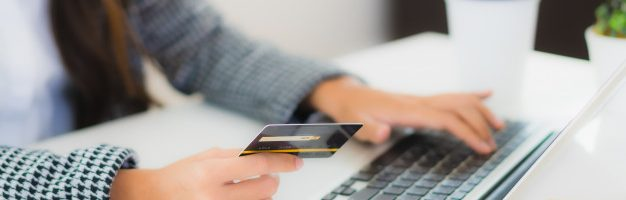

In [2]:
Image("img/capa.jpg")

## Business Problem

For the development of the project, we created a fictitious company called "Blocker Fraud Company", which is a company specialized in detecting fraud in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” in which it guarantees the blocking of fraudulent transactions.

The company's business model is of the Service type with the monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the client's transactions.

However, the Blocker Fraud Company is expanding in Brazil and to acquire customers more quickly, it has adopted a very aggressive strategy. The strategy works as follows:


- **1** - The company receives 25% of each transaction value truly detected as fraud.
- **2** - The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
- **3** - The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

###  What do we need to show? 

- What is the model's Precision and Accuracy?
- How Reliable is the model in classifying transactions as legitimate or fraudulent?
- What is the Expected Billing by the Company if we classify 100% of transactions with the model?

Below you can see the entire development of the project in the following topics.

### Index

- 0.0. Imports.
    - 0.1. Helper Functions
    - 0.2. Loading Data
    - 0.3. Sampling the Data   
- 1.0. Data description.
    - 1.1. Rename Columns
    - 1.2. Data Dimensions
    - 1.3. Data Types
    - 1.4. Check NA
    - 1.5. Descriptive Statistical
    
- 2.0. Feature Engineering
    - 2.1.MindMap Hypothesis
    - 2.2.Hypothesis List
    - 2.3.Final Hypothesis List
    - 2.4. Feature Engineering 
- 3.0. Filtering the features
    - 3.1.Filtering Columns
    - 3.2.Filtering Rows
    
- 4.0. Exploratory Data Analysis
    - 4.1.Univariate Analysis
    - 4.2.Bivariate Analysis
    - 4.3.Multivariate Analysis
- 5.0. Data preparation
    - 5.1. Rescaling
    - 5.2. Encoding
- 6.0. Feature selection
    - Recursive Feature Elimination (RFE)
    - RandomForest as Feature Selector
    - Boruta as Feature Selector
- 7.0. Balanced Data
    - Smote + Tomeklink (Random Oversampling + Random Undersampling)
- 8.0. Machine Learning Modelling
    - 8.1. Logistic Regression
    - 8.2. Stochastic Gradient Descent
    - 8.3. RandomForest Classifier
    - 8.4. LGBM Classifier
    - 8.5. Machine Learning Performance
- 9.0. Hyperparameter Fine Tunning
    - 9.1. RandomSearch CV
    - 9.2. Fit the model with the best parameters
    - 9.3. Real Performance - Cross-Validation
    
- 10.0. Model Calibration
- 11.0. Business Performance
    - 11.1. Financial Return
    - 11.2. Model's Performance and Business

# 0.0. IMPORTS

In [16]:
#data manipulation
import pandas as pd
import numpy as np

#data viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#balanced data
from imblearn                import under_sampling as us
from imblearn                import over_sampling as os
from imblearn                import combine as c

#data preparation
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,RandomizedSearchCV

#machine learning algorithms
from sklearn.ensemble        import RandomForestClassifier,ExtraTreesClassifier,IsolationForest
from sklearn.linear_model    import LogisticRegression,SGDClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import svm
from lightgbm                import LGBMClassifier

#metrics
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from scikitplot              import metrics      as mt
from sklearn.calibration     import calibration_curve,CalibratedClassifierCV

#feature selection
from sklearn.feature_selection import RFE
from boruta                  import BorutaPy

#auxiliar packages
from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats
import inflection
import pickle
import warnings
import json
import os
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

# point biserial correlation coefficient heatmap function
def point_bi(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name),fontsize = 25);

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

**Dataset Summary**

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [4]:
#reading csv
df_raw = pd.read_csv("data/data_fraud.csv")

In [5]:
#test data
test_data = df_raw.sample(1000)

In [7]:
#print 5 rows of dataset
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 0.2.1. Sampling the Data

In [8]:
#df_raw_is_fraud
df_raw_fraud = df_raw[df_raw['isFraud'] == 1]

In [9]:
#df_raw_is_not_fraud
df_raw_is_not_fraud = df_raw[df_raw['isFraud'] == 0].sample(1000000)

In [10]:
#concat data
df_raw_sample = pd.concat([df_raw_fraud,df_raw_is_not_fraud], axis = 0)

In [11]:
df_raw_sample.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


### 0.2.2. Check if we have the same proportion

In [12]:
#before sampling 
print("Before Sampling\n ")
df_raw['type'].value_counts(normalize = True)

Before Sampling
 


CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

In [13]:
print("After Sampling\n")
df_raw_sample['type'].value_counts(normalize = True)

After Sampling



CASH_OUT    0.352657
PAYMENT     0.335535
CASH_IN     0.218440
TRANSFER    0.086955
DEBIT       0.006413
Name: type, dtype: float64

- As we can see above, we keep the same proportion after sampling.

# 1.0. DATA DESCRIPTION

In [14]:
#copying data
df1 = df_raw_sample.copy()

In [15]:
#check columns names
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## 1.1. Rename Columns

Here, let's rename the columns to be more easier to our queries. We'll use a snake case pattern that refers to the style of writing in which each space is replaced by an underscore (_) character, and the first letter of each word written in lowercase. It is the most common naming convention used in computing as identifiers for variable, function, and file names. 

In [16]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))
cols_new

['step',
 'type',
 'amount',
 'name_orig',
 'oldbalance_org',
 'newbalance_orig',
 'name_dest',
 'oldbalance_dest',
 'newbalance_dest',
 'is_fraud',
 'is_flagged_fraud']

In [17]:
#change columns names
df1.columns = cols_new
df1.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


## 1.2. Data Dimensions

Let's understand how big our dataset is. This will be important because a robust machine learning model needs a considerable amount of data to train our algorithm.

In [18]:
#print data dimensions
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 1008213
Number of columns: 11


Although we have a lot of data, we need to know if our computational capacity is sufficient. If a problem appears during the project, it will be necessary to use a GPU.

## 1.3. Data Types

In [19]:
#print data types
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

Apparently our dataset does not have inconsistent data types.

## 1.4. Check NA

We will check if there are null values, if any, it will be necessary to study the cause to fix it.

In [20]:
#check missing values
df1.isnull().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

As we can see, we do not have null values, this will save us a lot of work.

## 1.5. Descriptive Statistical

This step is essential. It is necessary that we separate the numerical variables from the categorical variables. Because each will have a different form of analysis.

In [21]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64'])

### 1.5.1. Numerical Attributes

In [22]:
#central tendency - mean and median
ct1 = pd.DataFrame(np.round(num_attributes.apply(np.mean),2)).T
ct2 = pd.DataFrame(np.round(num_attributes.apply(np.median),2)).T

#dipersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(np.round(num_attributes.apply(np.std))).T
d2 = pd.DataFrame(np.round(num_attributes.apply(min))).T
d3 = pd.DataFrame(np.round(num_attributes.apply(max))).T
d4 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.max() - x.min()))).T
d5 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.skew()),2)).T
d6 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.kurtosis()),2)).T

#concat numerical attributes
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,743.0,742.0,244.41,244.00,143.0,0.39,0.34
1,amount,0.0,69886731.0,69886731.0,188648.72,75905.33,634569.0,25.87,1296.28
2,oldbalance_org,0.0,59585040.0,59585040.0,836693.27,14801.00,2883027.0,5.27,33.62
3,newbalance_orig,0.0,49585040.0,49585040.0,847735.67,0.00,2908081.0,5.21,32.61
4,oldbalance_dest,0.0,324915061.0,324915061.0,1094343.10,129441.73,3394864.0,20.00,948.97
5,newbalance_dest,0.0,355553416.0,355553416.0,1223403.84,214482.51,3674796.0,19.56,895.37
6,is_fraud,0.0,1.0,1.0,0.01,0.00,0.0,10.94,117.77
7,is_flagged_fraud,0.0,1.0,1.0,0.00,0.00,0.0,251.02,63008.62


- It's important to note that we don't have null values.
- is_flagged_fraud --> Most of the data in the "is_flagged_fraud" column is zero.
- oldbalance_org --> If we look at the median, which represents the intermediate value, we have the value of 14,691.00 However, the range is equal to  59,585,040.00, which is very high. This variable will need to be checked soon.
- newbalance_org, oldbalance_dest, newbalance_dest, amount --> Respects the same behavior as the oldbalance_org variable

#### 1.5.1.1 Checking inconsistent variables.

<AxesSubplot:xlabel='newbalance_dest'>

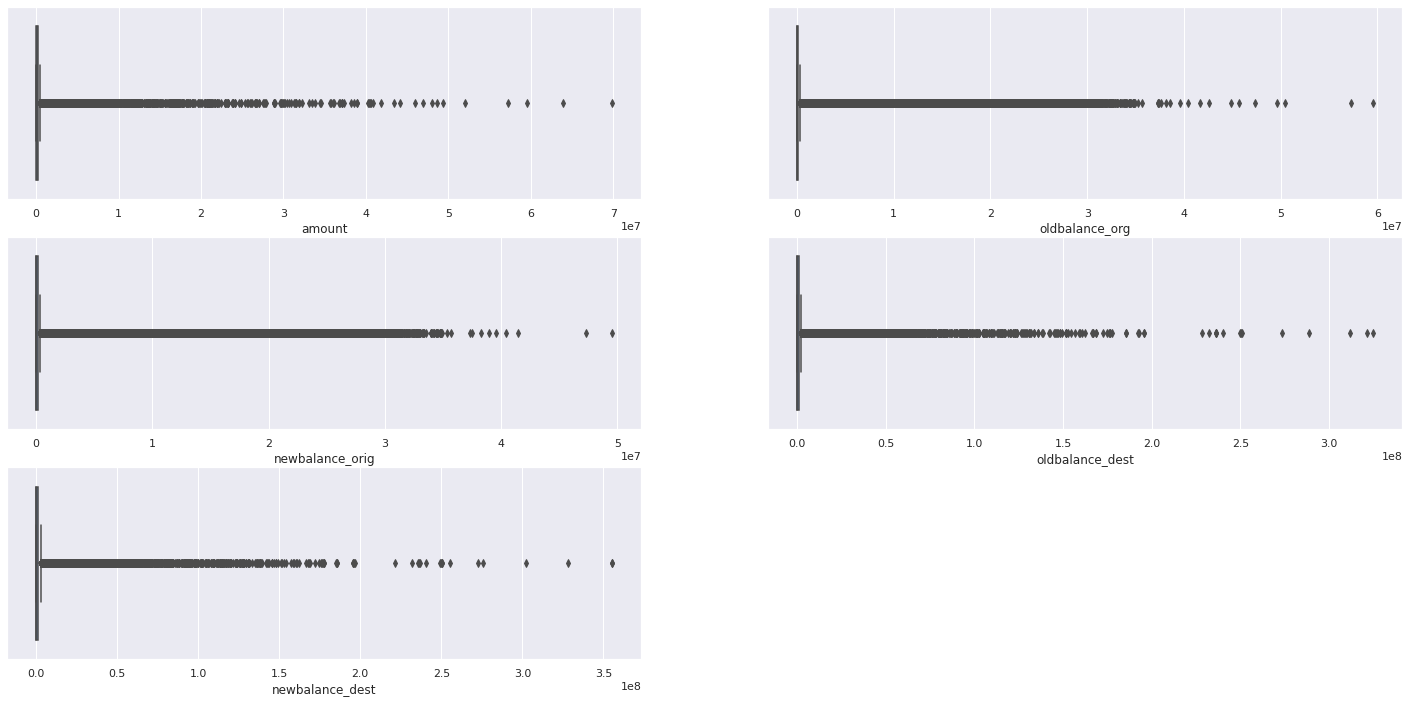

In [23]:
#amount
plt.subplot(3,2,1)
sns.boxplot(df1['amount'])

#oldbalance_org
plt.subplot(3,2,2)
sns.boxplot(df1['oldbalance_org'])

#newbalance_org
plt.subplot(3,2,3)
sns.boxplot(df1['newbalance_orig'])

#oldbalance_dest
plt.subplot(3,2,4)
sns.boxplot(df1['oldbalance_dest'])

#newbalance_dest
plt.subplot(3,2,5)
sns.boxplot(df1['newbalance_dest'])

In [24]:
num_attributes.head()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
2,1,181.0,181.0,0.0,0.0,0.0,1,0
3,1,181.0,181.0,0.0,21182.0,0.0,1,0
251,1,2806.0,2806.0,0.0,0.0,0.0,1,0
252,1,2806.0,2806.0,0.0,26202.0,0.0,1,0
680,1,20128.0,20128.0,0.0,0.0,0.0,1,0


As we see above, there is a high concentration of values in a small range. So, there is a large presence of outliers in our data set, it will be necessary to fix this.

<AxesSubplot:xlabel='step', ylabel='Density'>

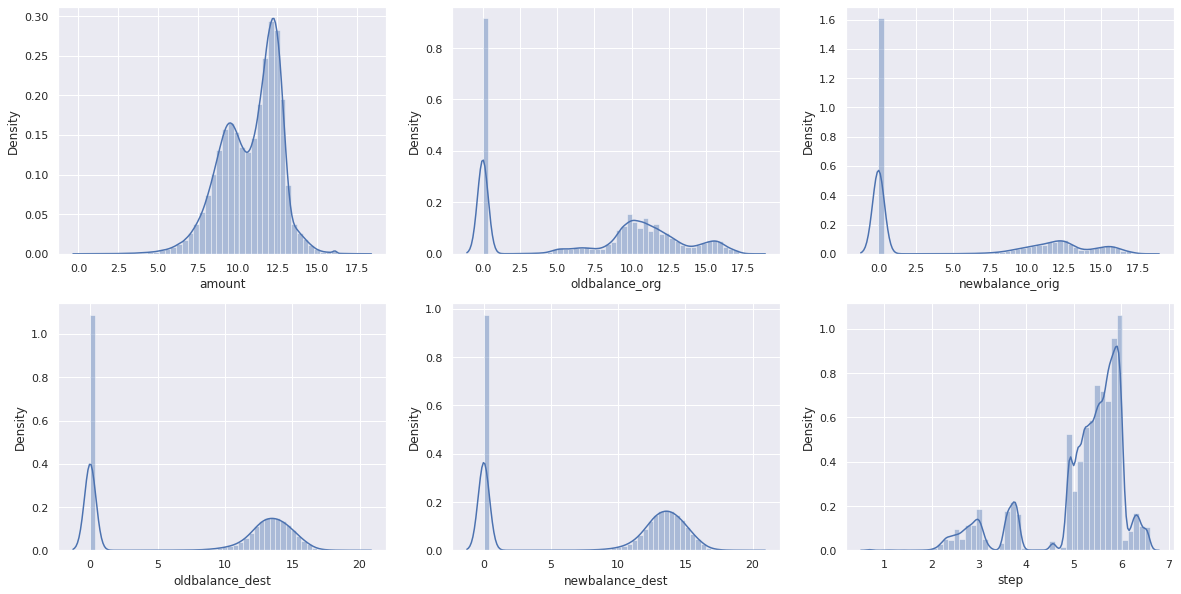

In [25]:
plt.figure(figsize = (20,10))

plt.subplot(2,3,1)
sns.distplot(np.log1p(num_attributes['amount']))  

plt.subplot(2,3,2)
sns.distplot(np.log1p(num_attributes['oldbalance_org']))

plt.subplot(2,3,3)
sns.distplot(np.log1p(num_attributes['newbalance_orig']))

plt.subplot(2,3,4)
sns.distplot(np.log1p(num_attributes['oldbalance_dest']))

plt.subplot(2,3,5)
sns.distplot(np.log1p(num_attributes['newbalance_dest']))

plt.subplot(2,3,6)
sns.distplot(np.log1p(df1['step']))

### 1.5.2. Categorical Attributes

In [26]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type               5
name_orig    1007966
name_dest     652587
dtype: int64

<AxesSubplot:xlabel='is_flagged_fraud', ylabel='count'>

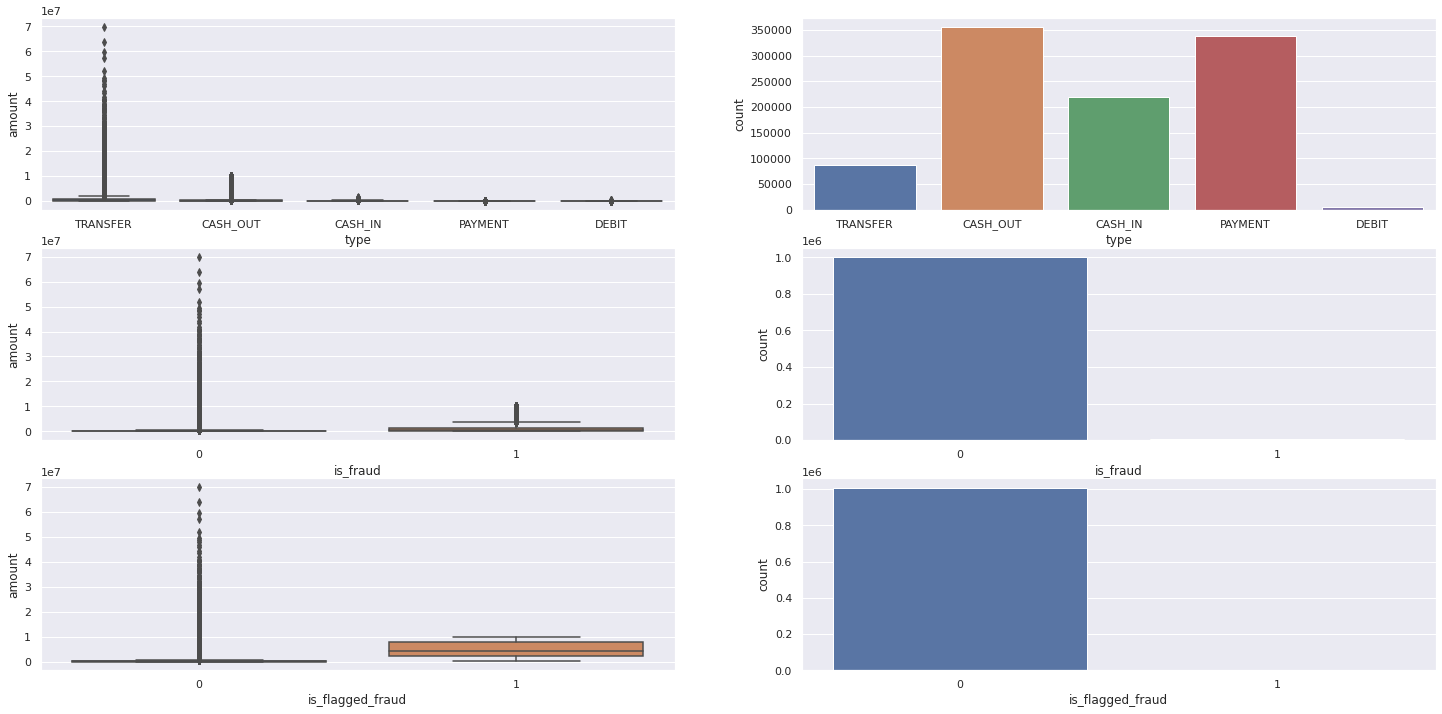

In [27]:
#plot boxplot to each variable
#type
plt.subplot(3,2,1)
sns.boxplot(x = 'type', y = 'amount', data = df1)

plt.subplot(3,2,2)
sns.countplot(cat_attributes['type'])

#is_fraud
plt.subplot(3,2,3)
sns.boxplot(x = 'is_fraud', y = 'amount', data = df1)

plt.subplot(3,2,4)
sns.countplot(df1['is_fraud'])

#is_flagged_fraud
plt.subplot(3,2,5)
sns.boxplot(x = 'is_flagged_fraud', y = 'amount', data = df1)

plt.subplot(3,2,6)
sns.countplot(df1['is_flagged_fraud'])

In [28]:
#check our is_fraud feature
df1['is_fraud'].value_counts(normalize = True)

0    0.991854
1    0.008146
Name: is_fraud, dtype: float64

- Only 0.8% of our data is considered fraudulent.
- High presence of outliers who transferred to our type variable.
- Cash_out is the most common form of payment, followed by payment.

# 2.0. FEATURE ENGINEERING

In [29]:
df2 = df1.copy()

## 2.1. MindMap Hypothesis

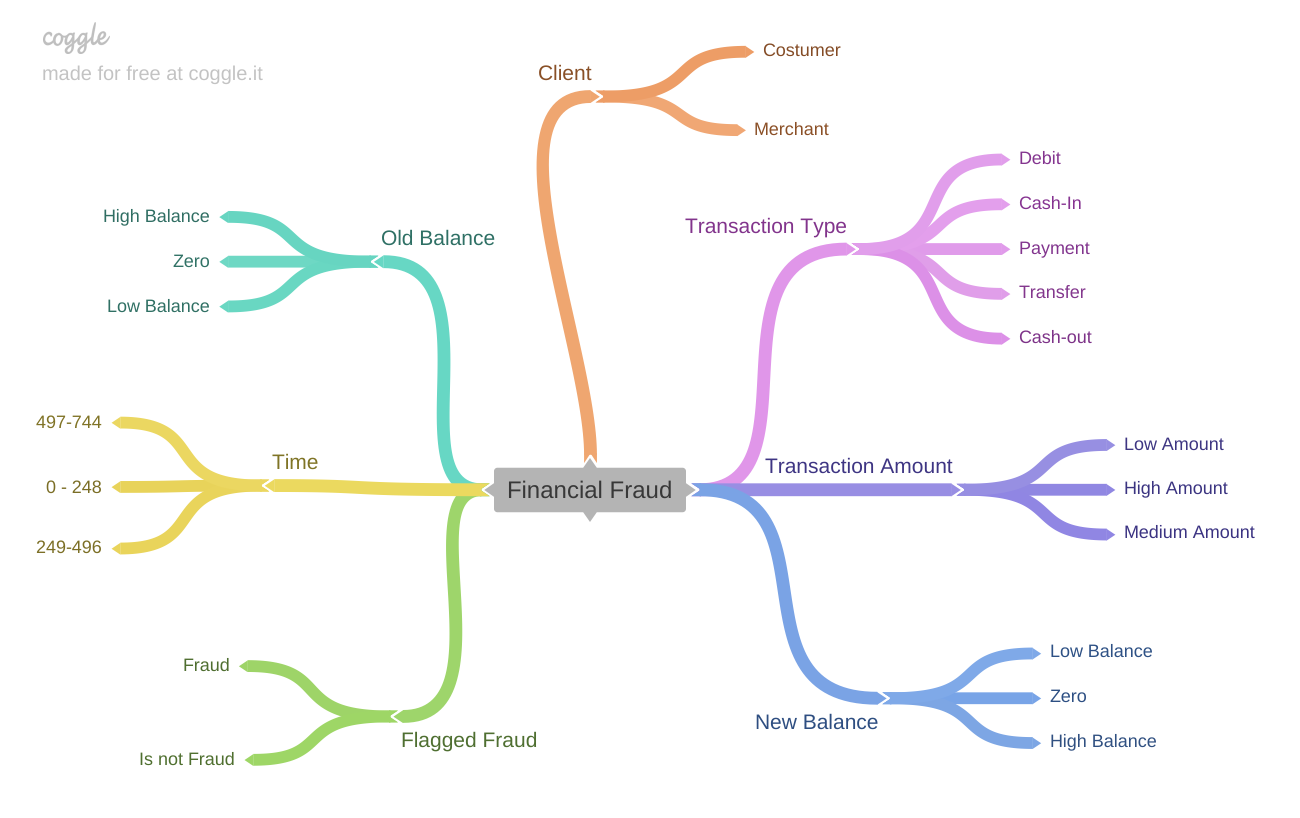

In [30]:
Image('img/Financial_Fraud.png')

## 2.2. Hypothesis List

**1** **Amount**
    - High value transactions are more likely to be fraudulent.
    
**2** **Type**
    - There are more cases of transfer fraud.

**3** **Original Balance**
    - There should be no fraud when the original balance is zero.
    - There is more chance of having fraud when the final balance is zero.
    - Very high value transactions are more likely to be fraudulent.
    
**4** **Destination Balance**
    - Original balance equal to zero and final non-zero, are more likely to be fraudulent.
**5** **Client**
    - Fraud happens more to costumers than to merchants.

**6** **Flagged Fraud**
    - Transactions over $ 200,000.00 will always be fraud.

**7** **Step/Time**
    - There are one more fraudulent transactions in the first 15 days of the month.
    

## 2.3. Final Hypothesis List

**H1** - High value transactions are more likely to be fraudulent.
    
**H2** - There are more cases of transfer fraud.

**H3** - Original Balance**

**H4** - There is no fraud in accounts with a orignal balance equal zero.

**H5** - There is more chance of having fraud when the final balance is zero.
    
**H6** - Very high value transactions are more likely to be fraudulent.
    
**H7** - Original balance equal to zero and final non-zero, are more likely to be fraudulent.

**H8** - Fraud happens more to costumers than to merchants.

**H9** - Transactions over $ 200,000.00 will always be fraud.

**H10** - There are one more fraudulent transactions in the first 15 days of the month.

## 2.4. Feature Engineering

In [31]:
#error balance 
df2['error_balance_orig'] = np.round((df2['newbalance_orig'] + df2['amount'] - df2['oldbalance_org']),2)
df2['error_balance_dest'] = df2['newbalance_dest'] + df2['amount'] - df2['oldbalance_dest']
df2['flow_orig'] = df2['newbalance_orig'] - df2['oldbalance_org']
df2['flow_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

#client
df2['client_dest'] = df2['name_dest'].apply(lambda x: "Merchant" if "M" in x else "Costumer")
df2['client_orig'] = df2['name_orig'].apply(lambda x: 'Merchant' if "M" in x else "Costumer")

#step
df2['day'] = df2['step'].apply(lambda x: int(x/24))

#weekend
df2['week_of_month'] = df2['day'].apply(lambda x: 1 if (x <=7) else 2 if (x <= 14) & (x>7) else 3 if (x > 14) & (x<=21) else 4)

#weekend
df2['weekend'] = df2['day'].apply(lambda x: 1 if (x == 7) or (x == 6) or (x == 14) or (x == 13) or (x == 20) or (x == 21) or (x == 27) or (x == 28) else 0)

In [32]:
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,0.0,181.0,-181.0,0.0,Costumer,Costumer,0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0.0,-21001.0,-181.0,-21182.0,Costumer,Costumer,0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,0.0,2806.0,-2806.0,0.0,Costumer,Costumer,0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,0.0,-23396.0,-2806.0,-26202.0,Costumer,Costumer,0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,0.0,20128.0,-20128.0,0.0,Costumer,Costumer,0,1,0


# 3.0. DATA FILTERING

In [33]:
df3 = df2.copy()

## 3.1. Filtering Columns

In [34]:
df3.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,0.0,181.0,-181.0,0.0,Costumer,Costumer,0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0.0,-21001.0,-181.0,-21182.0,Costumer,Costumer,0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,0.0,2806.0,-2806.0,0.0,Costumer,Costumer,0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,0.0,-23396.0,-2806.0,-26202.0,Costumer,Costumer,0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,0.0,20128.0,-20128.0,0.0,Costumer,Costumer,0,1,0


In the feature engineering section we created some features, therefore, we'll remove these is not necessary;

- name_orig - Feature created = client_orig
- name_dest - Feature created = client_dest

In [35]:
#removing features that will not necessary to us
df3.drop(columns = ['name_orig','name_dest'], axis = 1, inplace = True)

In [36]:
df3.head()

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend
2,1,TRANSFER,181.0,181.0,0.0,0.0,0.0,1,0,0.0,181.0,-181.0,0.0,Costumer,Costumer,0,1,0
3,1,CASH_OUT,181.0,181.0,0.0,21182.0,0.0,1,0,0.0,-21001.0,-181.0,-21182.0,Costumer,Costumer,0,1,0
251,1,TRANSFER,2806.0,2806.0,0.0,0.0,0.0,1,0,0.0,2806.0,-2806.0,0.0,Costumer,Costumer,0,1,0
252,1,CASH_OUT,2806.0,2806.0,0.0,26202.0,0.0,1,0,0.0,-23396.0,-2806.0,-26202.0,Costumer,Costumer,0,1,0
680,1,TRANSFER,20128.0,20128.0,0.0,0.0,0.0,1,0,0.0,20128.0,-20128.0,0.0,Costumer,Costumer,0,1,0


## 3.2. Filtering Rows

In the descriptive analysis section, we observed the presence of many outliers in our financial variables. We will treat them according to the distribution of the boxplot, since we do not have more information about the business.

In [37]:
#amount
df3_clean = df3[df3['amount'] < 2.108805e+06]

#oldbalance_org
df3_clean = df3[df3['oldbalance_dest'] < 9.384180e+06]

<AxesSubplot:xlabel='newbalance_dest'>

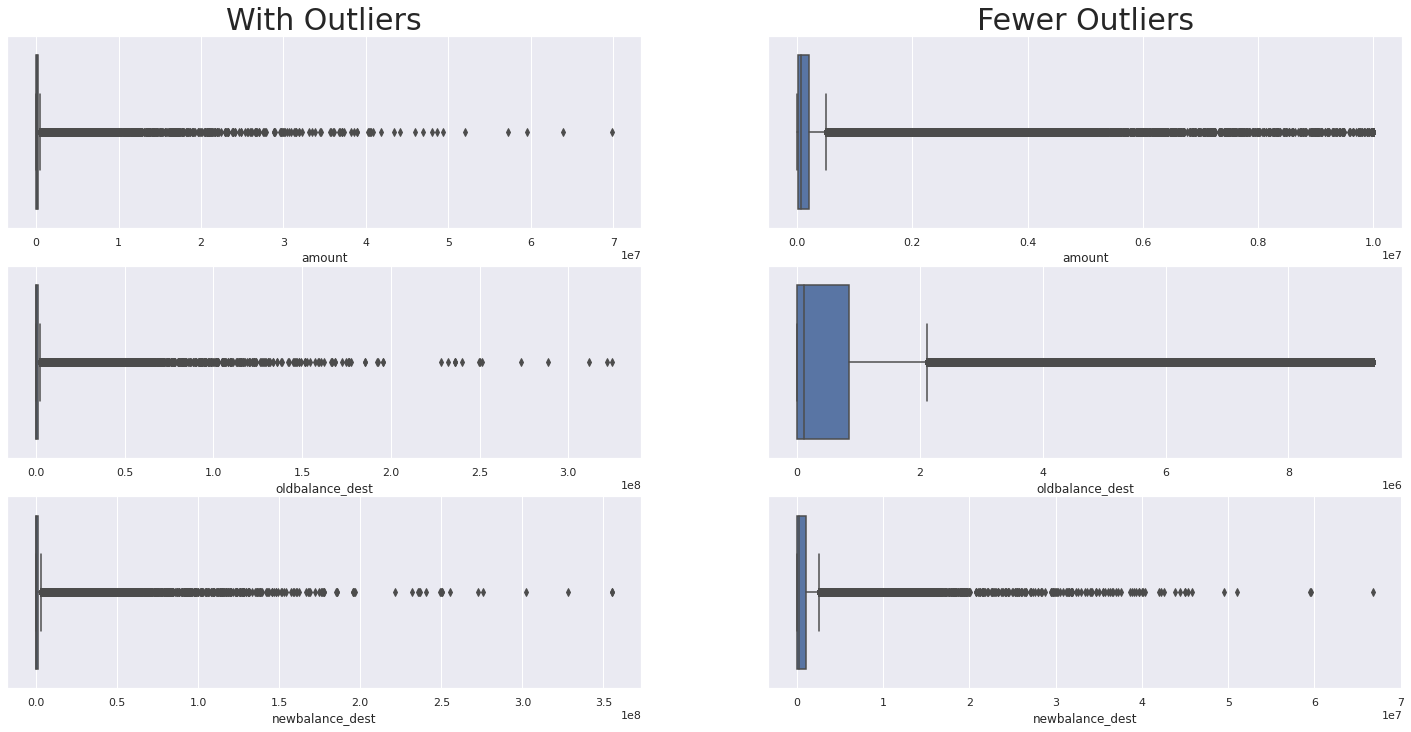

In [38]:
plt.subplot(3,2,1)
sns.boxplot(df3['amount'])
plt.title("With Outliers", fontsize = 30)

plt.subplot(3,2,2)
sns.boxplot(df3_clean['amount'])
plt.title("Fewer Outliers", fontsize = 30)

plt.subplot(3,2,3)
sns.boxplot(df3['oldbalance_dest'])

plt.subplot(3,2,4)
sns.boxplot(df3_clean['oldbalance_dest'])

plt.subplot(3,2,5)
sns.boxplot(df3['newbalance_dest'])

plt.subplot(3,2,6)
sns.boxplot(df3_clean['newbalance_dest'])

# 4.0. EXPLORATORY DATA ANALYSIS

In [39]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

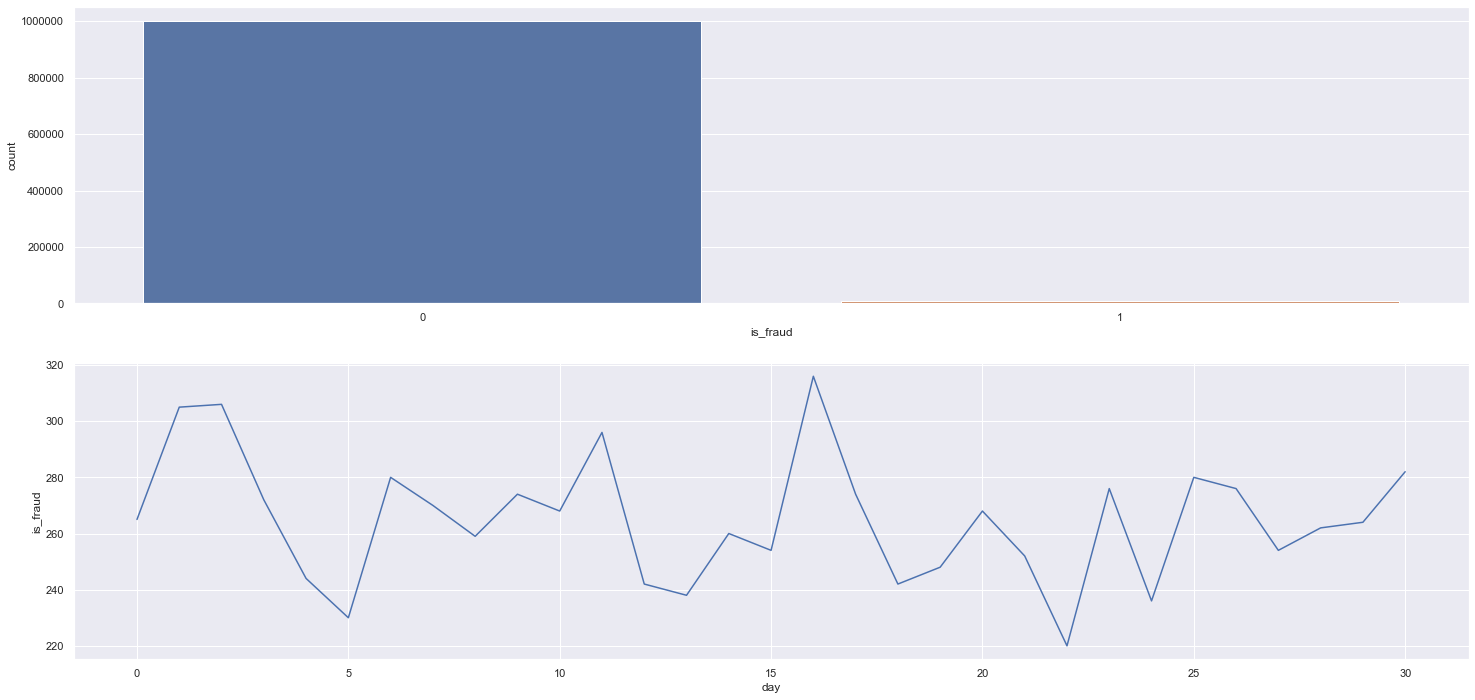

In [39]:
#ploting is_fraud feature
plt.subplot(2,1,1)
sns.countplot(df4['is_fraud'])

#plot our is_fraud feature per day
plt.subplot(2,1,2)
aux = df4[['day','is_fraud']].groupby("day").sum().reset_index()
sns.lineplot(x = 'day',y = 'is_fraud', data = aux)

In [40]:
#check proportion
is_fraud_list = [(df4[df4['is_fraud'] == 1].shape[0]/df4.shape[0])*100, (df4[df4['is_fraud'] == 0].shape[0]/df4.shape[0])*100]
df_fraud = pd.DataFrame(is_fraud_list).T
df_fraud.columns = ['Positive','Negative']
df_fraud

,Positive,Negative
0,0.81461,99.18539


- 99.2% of our data is not considered fraudulent, against 0.8% fraudulent.
- Fraud has a very oscillatory tendency in relation to days.

### 4.1.2. Numerical Variables

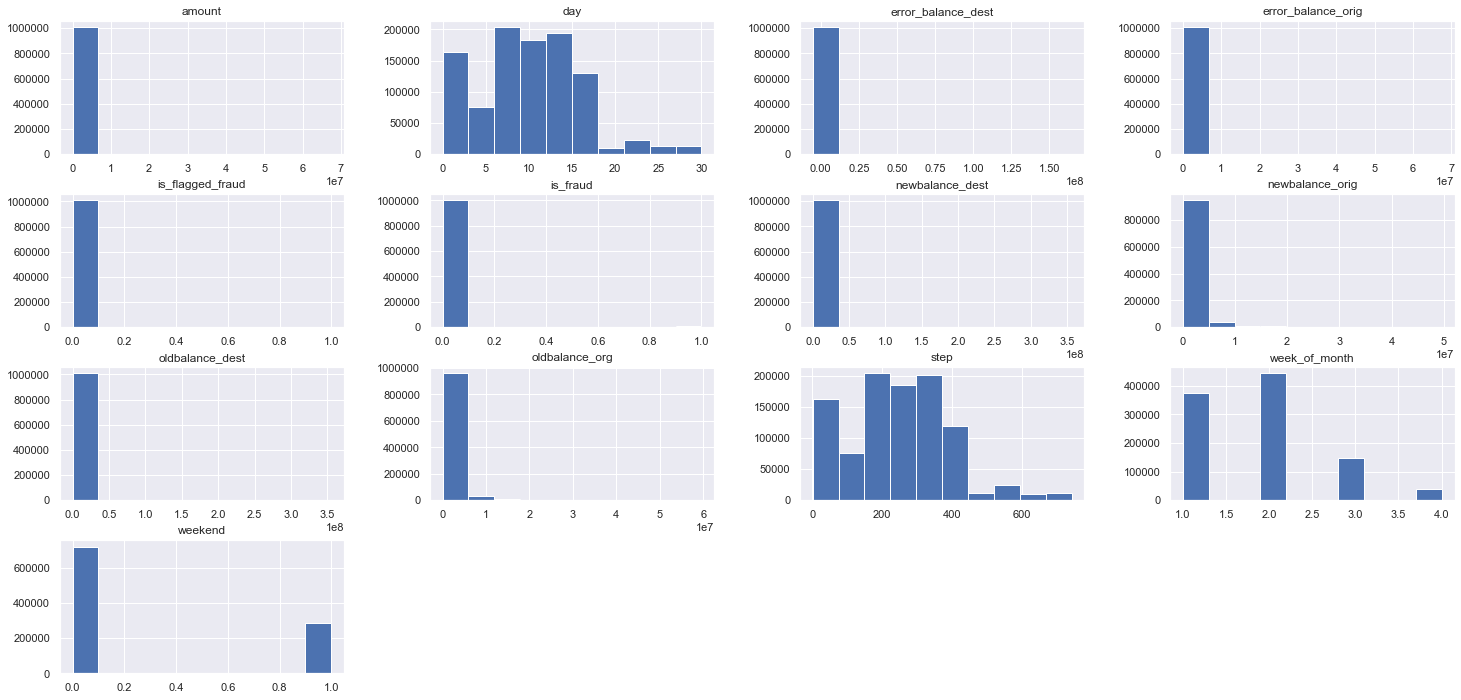

In [41]:
num_attributes = df4.select_dtypes(include = ['int64','float64'])
num_attributes.hist();

- Financial variables with high concentration of values in a small range.
- In the last 10 days of the month, there were far fewer transactions.
- The first two weeks had a higher number of transactions.
- There are more transactions on weekdays than on weekends. This is predictable due to the number of days.

### 4.1.3. Categorical Variables

In [42]:
cat_attributes = df4.select_dtypes(include = 'object')
cat_attributes.head()

,type,client_dest,client_orig
2,TRANSFER,Costumer,Costumer
3,CASH_OUT,Costumer,Costumer
251,TRANSFER,Costumer,Costumer
252,CASH_OUT,Costumer,Costumer
680,TRANSFER,Costumer,Costumer


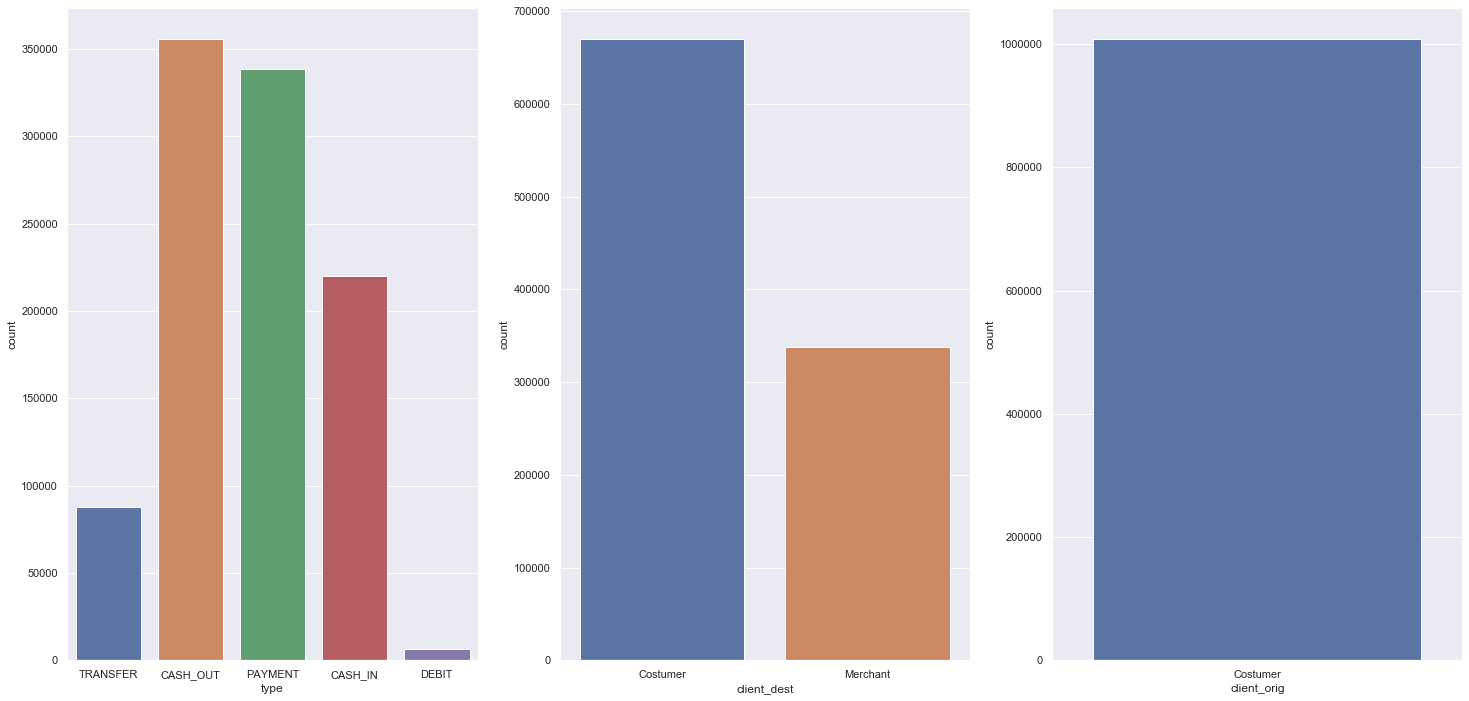

In [43]:
#type
plt.subplot(1,3,1)
sns.countplot(cat_attributes['type'])

#client_dest
plt.subplot(1,3,2)
sns.countplot(cat_attributes['client_dest'])

#client_orig
plt.subplot(1,3,3)
sns.countplot(cat_attributes['client_orig'])

- The most frequent types of transactions are, in descending order: CASH_OUT, PAYMENT, CASH_IN.
- There are twice as many transactions for Costumers as compared to Merchant.
- All transactions are made from Costumers. That is, there are no transactions executed by Merchant

## 4.2. Bivariate Analysis

### Summary of Hypothesis

**H1** - High value transactions are more likely to be fraudulent.
    
**H2** - There are more cases of transfer fraud.

**H3** - There should be no fraud when the original balance is zero.

**H4** - There is more chance of having fraud when the final balance is zero.
    
**H5** - Original balance equal to zero and final non-zero, are more likely to be fraudulent.

**H6** - Fraud happens more to costumers than to merchants.

**H7** - Transactions over $ 200,000.00 will always be fraud.

**H8** - There are one more fraudulent transactions in the first 15 days of the month.

### H1. High value transactions are more likely to be fraudulent

**True -** There are more fraudulent transactions with higher amounts.

Text(0.5, 1.0, 'Days x Amount')

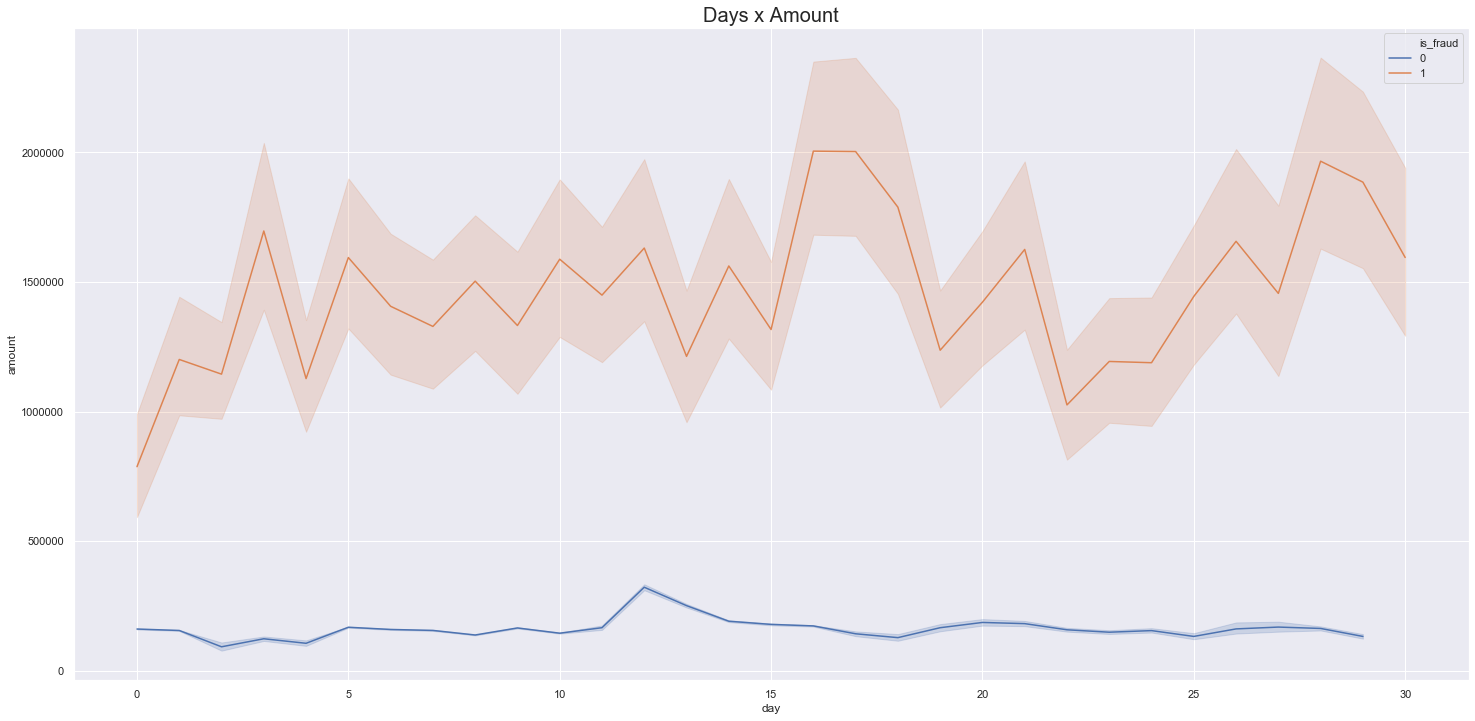

In [44]:
#plot days x amount 
sns.lineplot(x = 'day', y = 'amount', hue = 'is_fraud', data = df4)
plt.title("Days x Amount", fontsize = 20)

Text(0.5, 1, 'is_fraud x amount correlation heatmap')

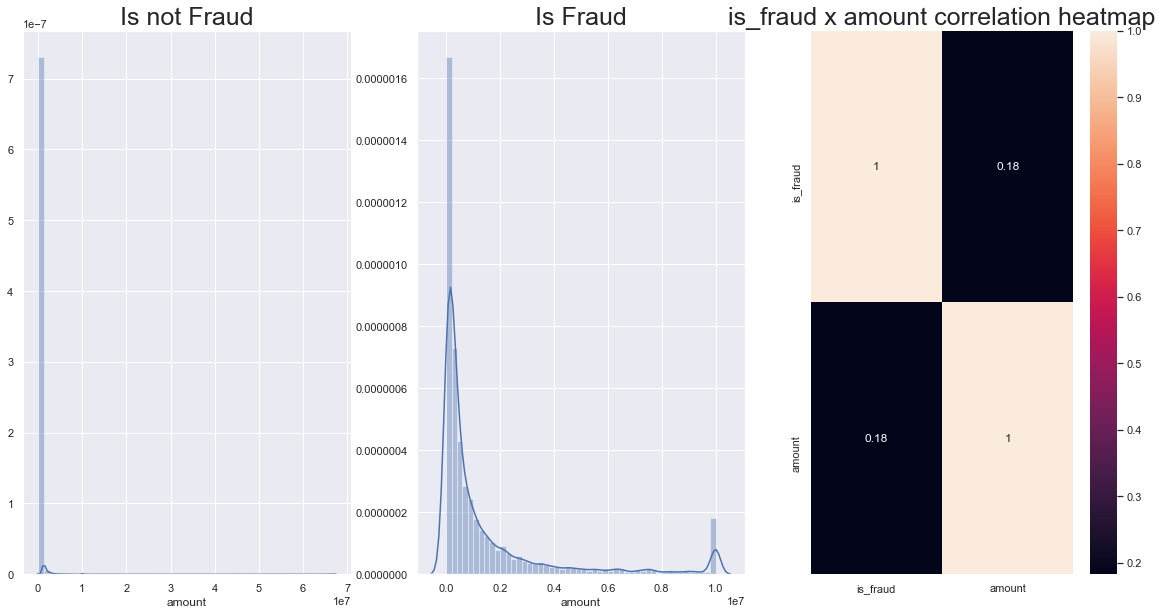

In [45]:
#histogram
plt.figure(figsize = (20,10))

#is not fraud
plt.subplot(1,3,1)
aux = df4[df4['is_fraud'] == 0]
sns.distplot(aux['amount'])
plt.title("Is not Fraud", fontsize = 25)

#is fraud
plt.subplot(1,3,2)
aux1 = df4[df4['is_fraud'] == 1]
sns.distplot(aux1['amount'], kde = True)
plt.title("Is Fraud", fontsize = 25)

plt.subplot(1,3,3)
#correlation between amount and is_fraud 
point_bi(df4[['is_fraud']], df4[['amount']])

In [46]:
#check the descriptive statistical
aux.describe()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,day,week_of_month,weekend
count,1000000.000000,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1000000.0,1000000.0,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000
mean,243.254011,1.779891e+05,8.282069e+05,8.513033e+05,1.101439e+06,1.225368e+06,0.0,0.0,2.010855e+05,3.019176e+05,9.496889,1.849780,0.285943
std,142.172544,5.890583e+05,2.870122e+06,2.907975e+06,3.417070e+06,3.696250e+06,0.0,0.0,5.999143e+05,1.360655e+06,5.915017,0.806836,0.451863
min,1.000000,7.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,-1.000000e-02,-5.263391e+06,0.000000,1.000000,0.000000
25%,156.000000,1.344054e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,3.031832e+03,3.828858e+03,6.000000,1.000000,0.000000
50%,239.000000,7.499908e+04,1.421200e+04,0.000000e+00,1.336473e+05,2.155826e+05,0.0,0.0,6.927620e+04,2.782947e+04,9.000000,2.000000,0.000000
75%,334.000000,2.085742e+05,1.071322e+05,1.450908e+05,9.428852e+05,1.111196e+06,0.0,0.0,2.500624e+05,3.082890e+05,13.000000,2.000000,1.000000
max,718.000000,6.750076e+07,3.893942e+07,3.894623e+07,3.553805e+08,3.560159e+08,0.0,0.0,6.750076e+07,1.645596e+08,29.000000,4.000000,1.000000


Text(0.5, 1, 'is_fraud x amount correlation heatmap')

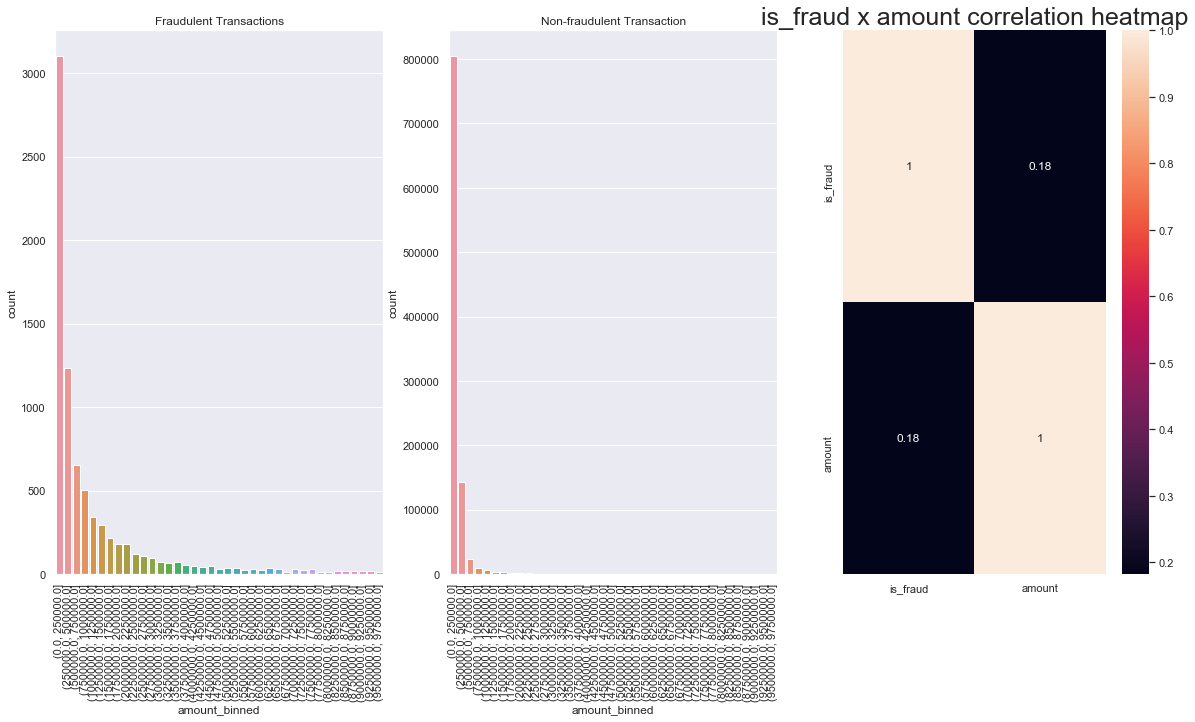

In [47]:
#filtering is_fraud equal 1
aux_01 = df4[df4['is_fraud'] == 1]
bins = list(np.arange(0,1e7,2.5e5))
aux_01['amount_binned'] = pd.cut(aux_01['amount'], bins = bins)

#filtering is_fraud equal 0
aux_0 = df4[df4['is_fraud'] == 0]
bins = list(np.arange(0,1e7,2.5e5))
aux_0['amount_binned'] = pd.cut(aux_0['amount'],bins = bins)


#plotting graphs
plt.figure(figsize = (20,10))
plt.subplot(1,3,1)
sns.countplot(aux_01['amount_binned'])
plt.xticks(rotation = 90);
plt.title("Fraudulent Transactions")

plt.subplot(1,3,2)
sns.countplot(aux_0['amount_binned'])
plt.xticks(rotation = 90);
plt.title("Non-fraudulent Transaction")

plt.subplot(1,3,3)
point_bi(df4[['is_fraud']], df4[['amount']])

- The more the amount increases, the more cases of fraudulent than legitimate transactions.
- The correlation between the variable amount and is_fraud is positive and low.
- From the graphs above, we can conclude that the hypothesis is true.

### H2. There are more cases of transfer fraud
**True -** There are more cases in transactions that were made through transfer.

Text(0.5, 1.0, 'Only Fraudulent')

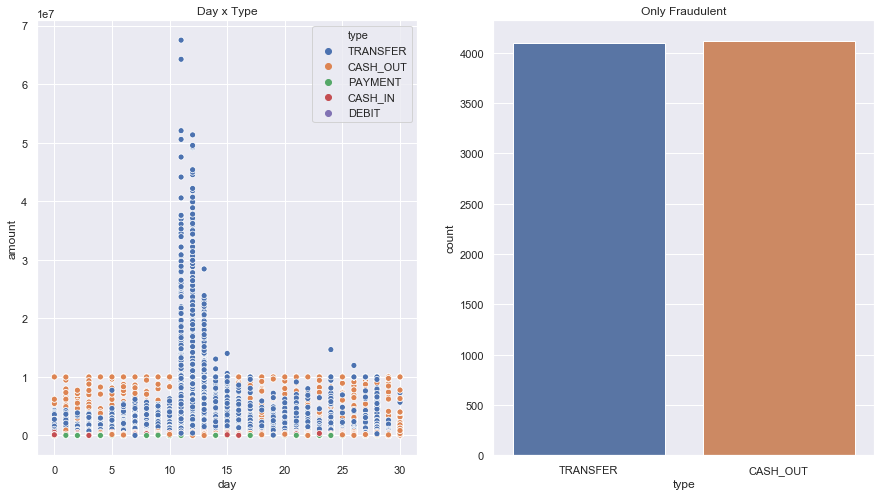

In [48]:
plt.figure(figsize = (15,8))

plt.subplot(1,2,1)
sns.scatterplot(x = 'day', y = 'amount', hue = 'type', data = df4)
plt.title("Day x Type")

plt.subplot(1,2,2)
aux = df4[df4['is_fraud'] == 1]
sns.countplot(aux['type'])
plt.title("Only Fraudulent")

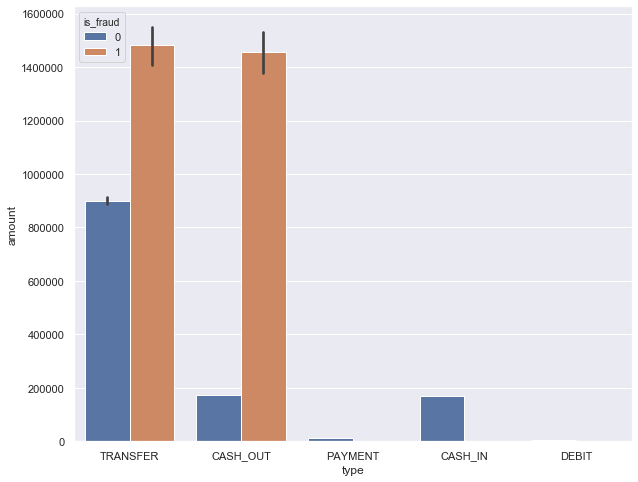

In [49]:
plt.figure(figsize = (10,8))
sns.barplot(x = 'type', y = 'amount', hue = 'is_fraud', data = df4)

- There are cases of fraud only through transfer and cash out.
- Transactions with higher amounts are usually transfer and cash_out.
- The sum of the values of fraudulent transactions is much larger than legitimate ones.

### H3. There should be no fraud when the original balance is zero.

**True -** Fraud is not common when oldbalance_org is zero

Text(0.5, 1, 'is_fraud x oldbalance_org correlation heatmap')

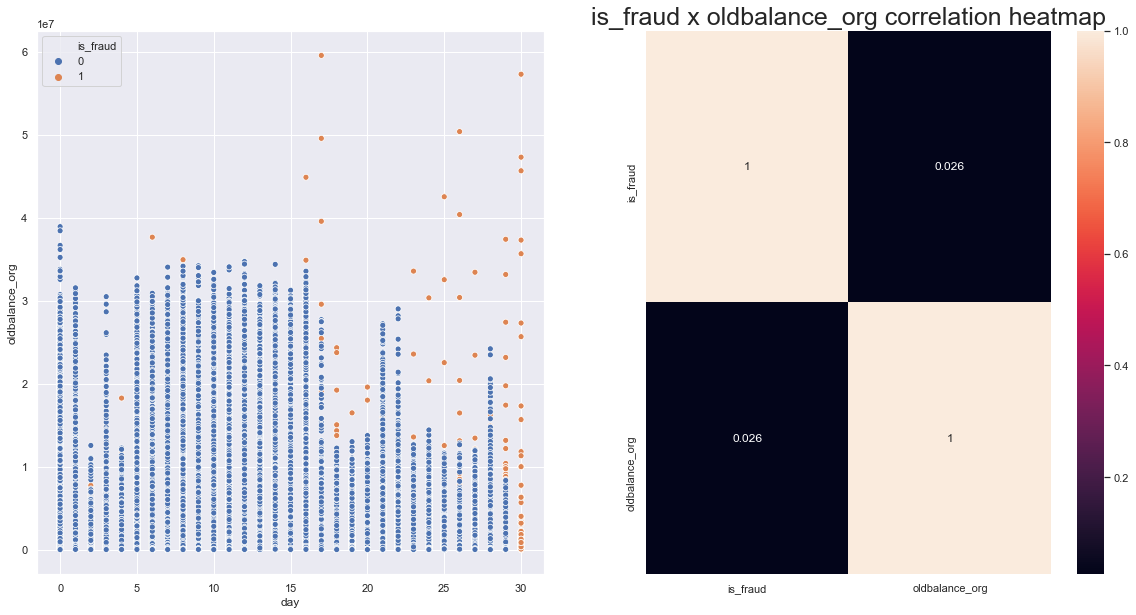

In [50]:
#day x oldbalance_org
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
sns.scatterplot(x = 'day', y = 'oldbalance_org', hue = 'is_fraud', data = df4)

#correlation between is_fraud and oldbalance_org
plt.subplot(1,2,2)
point_bi(df4[['is_fraud']], df4[['oldbalance_org']])

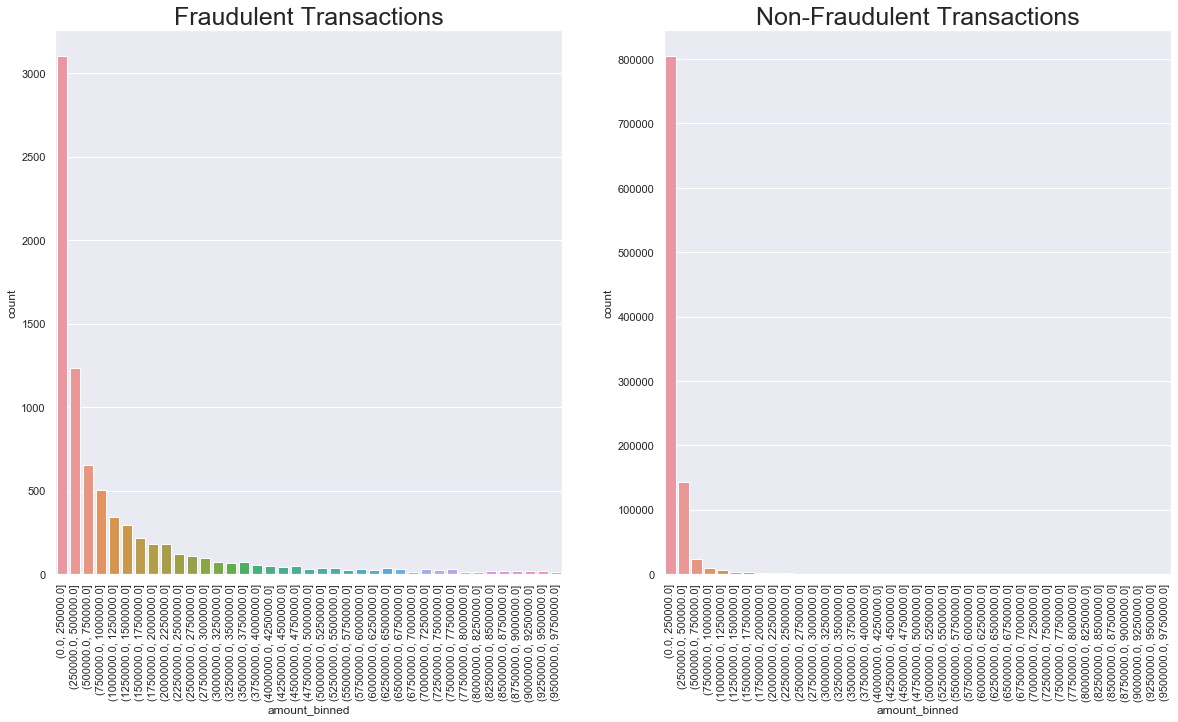

In [51]:
#filtering is_Fraud equal 1
aux_01 = df4[df4['is_fraud'] == 1]

bins = list(np.arange(0,1e7,2.5e5))
aux_01['amount_binned'] = pd.cut(aux_01['amount'], bins = bins)


#filtering is_fraud equal 0
aux_00 = df4[df4['is_fraud'] == 0]
aux_00['amount_binned'] = pd.cut(aux_00['amount'], bins = bins)


#plotting graphs

#is_fraud == 1
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
sns.countplot(aux_01['amount_binned'])
plt.title("Fraudulent Transactions", fontsize = 25)
plt.xticks(rotation = 90);

#is_fraud == 0
plt.subplot(1,2,2)
sns.countplot(aux_00['amount_binned'])
plt.title("Non-Fraudulent Transactions", fontsize = 25)
plt.xticks(rotation = 90);

In [52]:
#percentage is fraud
df_is_fraud = pd.DataFrame(
    aux_01['amount_binned'].value_counts(normalize=True)).reset_index()
df_is_fraud.columns = ['Value Range', 'Fraudulent Percentage']
df_is_fraud

,Value Range,Fraudulent Percentage
0,"(0.0, 250000.0]",0.392504
1,"(250000.0, 500000.0]",0.156115
2,"(500000.0, 750000.0]",0.082932
3,"(750000.0, 1000000.0]",0.063687
4,"(1000000.0, 1250000.0]",0.043175
5,"(1250000.0, 1500000.0]",0.036971
6,"(1500000.0, 1750000.0]",0.027349
7,"(2000000.0, 2250000.0]",0.023044
8,"(1750000.0, 2000000.0]",0.022411
9,"(2250000.0, 2500000.0]",0.015194


In [53]:
#percentagem is not fraud
df_is_not_fraud = pd.DataFrame(aux_00['amount_binned'].value_counts(normalize = True)).reset_index()
df_is_not_fraud.columns = ['Value range','Non-fraudulent percentage']
df_is_not_fraud

,Value range,Non-fraudulent percentage
0,"(0.0, 250000.0]",0.804893
1,"(250000.0, 500000.0]",0.142844
2,"(500000.0, 750000.0]",0.024101
3,"(750000.0, 1000000.0]",0.008797
4,"(1000000.0, 1250000.0]",0.005625
5,"(1250000.0, 1500000.0]",0.003696
6,"(1500000.0, 1750000.0]",0.002419
7,"(1750000.0, 2000000.0]",0.001784
8,"(2000000.0, 2250000.0]",0.001242
9,"(2250000.0, 2500000.0]",0.000918


- As we can see above, fraudulent transactions usually happen when oldbalance_org is greater than zero.

- The variables oldbalance_org and is_fraud have a low positive correlation.

- 80% of the values that are not fraudulent are within the range 0 to 250,000.

- We can say that the hypothesis is true.

### **H4**. There is more chance of having fraud when the final balance is zero.

**True -** 98% of fraudulent data occurs when the final balance is equal zero

Text(0.5, 1, 'is_fraud x newbalance_orig correlation heatmap')

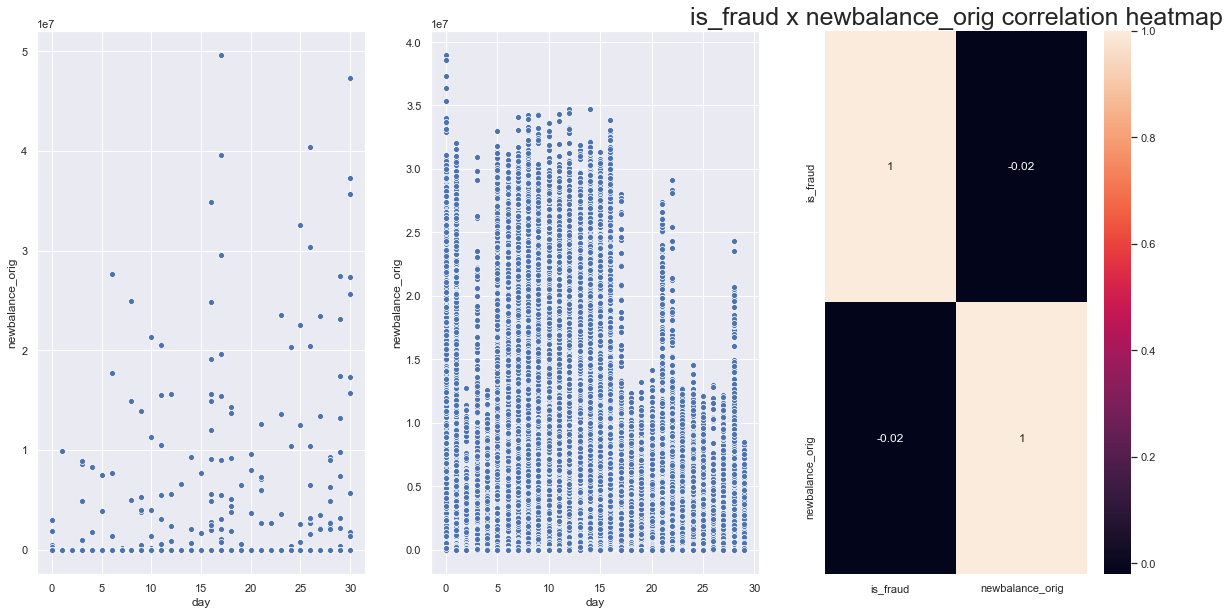

In [54]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1)
aux_1 = df4[df4['is_fraud'] == 1]
sns.scatterplot(x = 'day', y = 'newbalance_orig', data = aux_1)

plt.subplot(1,3,2)
aux_0 = df4[df4['is_fraud'] == 0]
sns.scatterplot(x = 'day', y = 'newbalance_orig', data = aux_0)

plt.subplot(1,3,3)
point_bi(df4[['is_fraud']],df4[['newbalance_orig']])

In [55]:
df_new_balance_orig = pd.DataFrame([aux_1[aux_1['newbalance_orig'] == 0].shape[0]/aux_1.shape[0], aux_0[aux_0['newbalance_orig'] == 0].shape[0]/aux_0.shape[0]]).T
df_new_balance_orig.columns = ['Fraudulent','Non-Fraudulent']
df_new_balance_orig

,Fraudulent,Non-Fraudulent
0,0.980519,0.566415


- 98% of the fraudulent data had an original final balance of zero.

- It has a very low and negative correlation.

- 56% of non-fradulent data had a final balance of zero.

- From the conclusions, we can say that the hypothesis is true.

### H5. Fraud happens more to costumers than to merchants.

**True -** There's just fraudulent transactions to costumers.

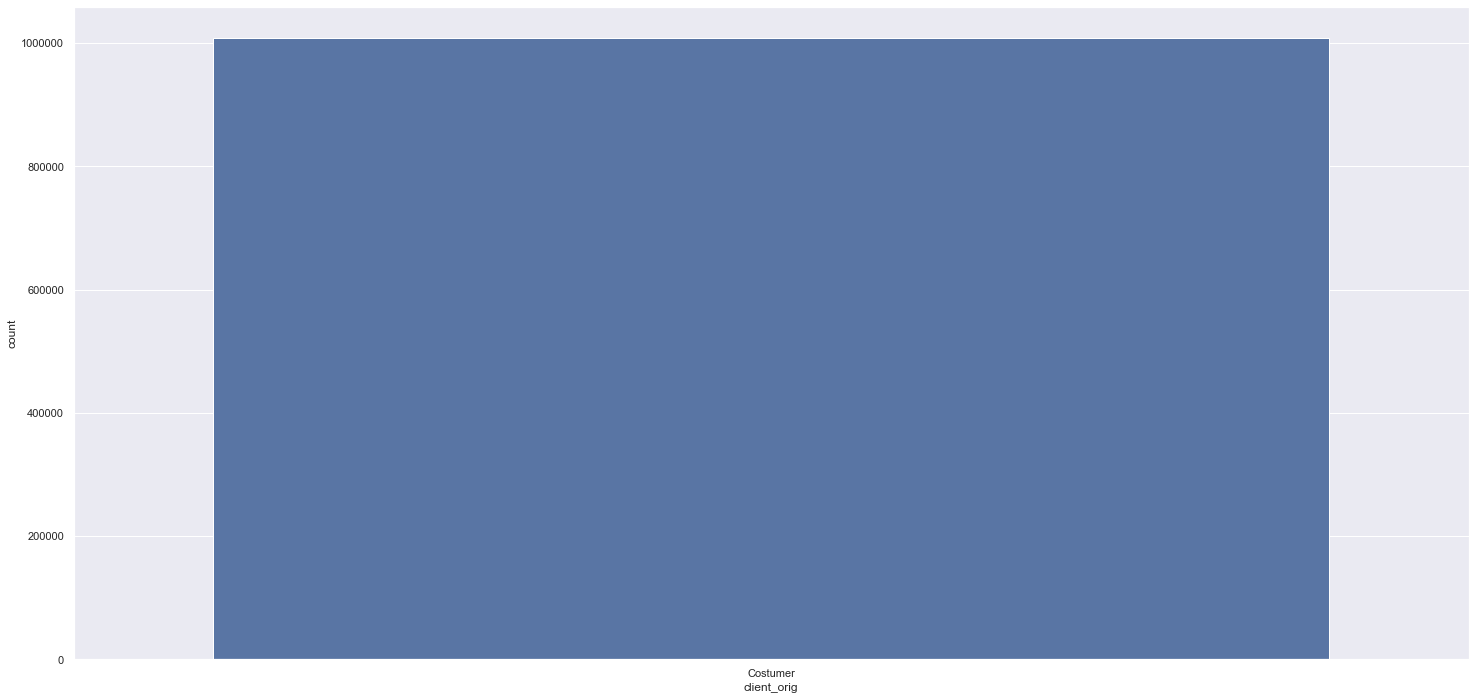

In [56]:
aux = df4[df4['is_fraud'] == 1] 
sns.countplot(df4['client_orig'])

In [57]:
aux = df4[['client_orig','is_fraud']].groupby(["is_fraud",'client_orig']).size().reset_index()
aux = aux.rename(columns = {0: 'count'})
aux

,is_fraud,client_orig,count
0,0,Costumer,1000000
1,1,Costumer,8213


- All the fradulent transactions occurs to costumers
- Therefore, it doesn't exist fraudulent transactions to merchants in our dataset.
- From the plot above, we can say that our hypothesis is true.

### H6.  Transactions over $ 200,000.00 will always be fraud.

**False -** Transactions over $200.000,00 are not usually fraudulent.

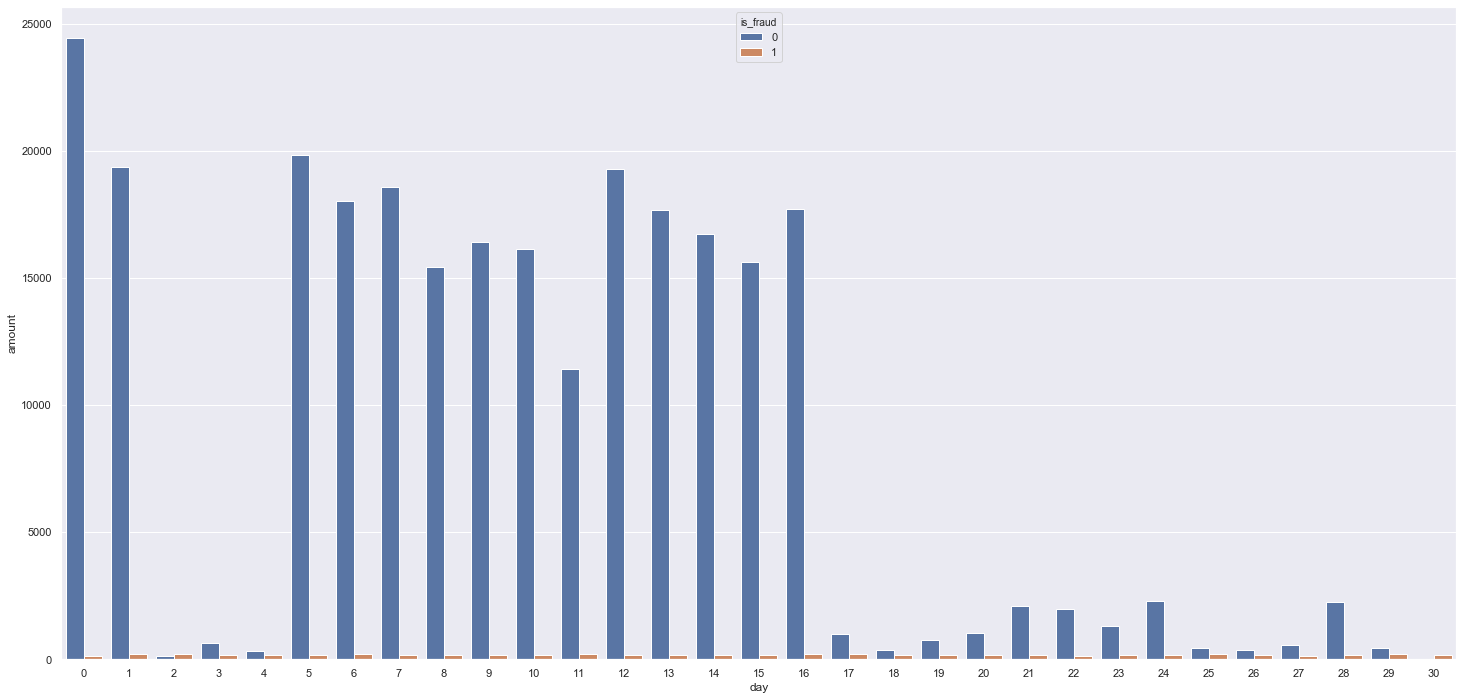

In [58]:
aux = df4[df4['amount'] > 200000]

aux1 = aux[['amount','day','is_fraud']].groupby(["day",'is_fraud']).count().reset_index()

sns.barplot(x = 'day', y = 'amount', hue = 'is_fraud', data = aux1)

### **H7** - There are one more fraudulent transactions in the first 15 days of the month.
**False -** As a percentage, we have more fraudulent transactions after the first 15 days of the month.

Text(0.5, 1.0, 'Fraud by Day')

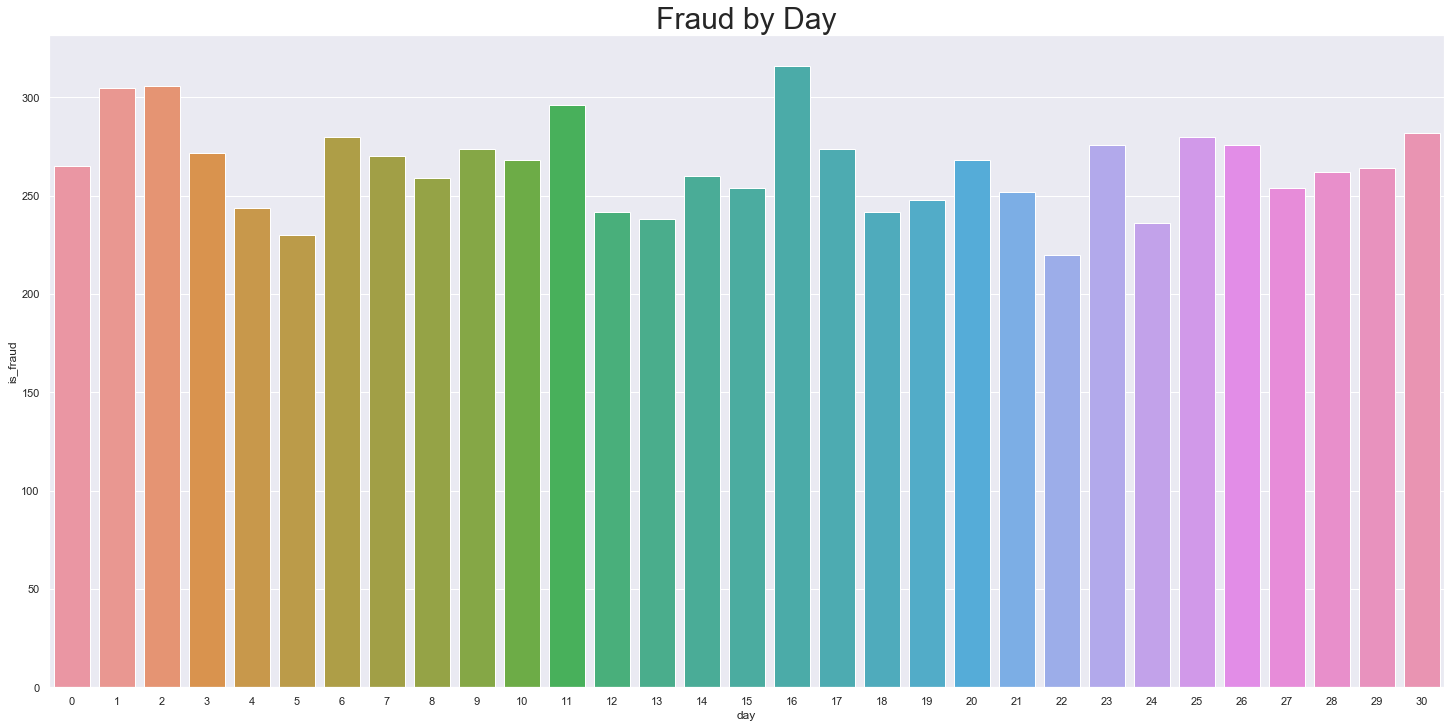

In [59]:
#count of fradulent transactions
aux = df4[df4['is_fraud'] == 1]
aux1 = aux[['is_fraud','day']].groupby("day").count().reset_index()

sns.barplot(x = 'day', y = 'is_fraud', data = aux1)
plt.title("Fraud by Day", fontsize = 30)

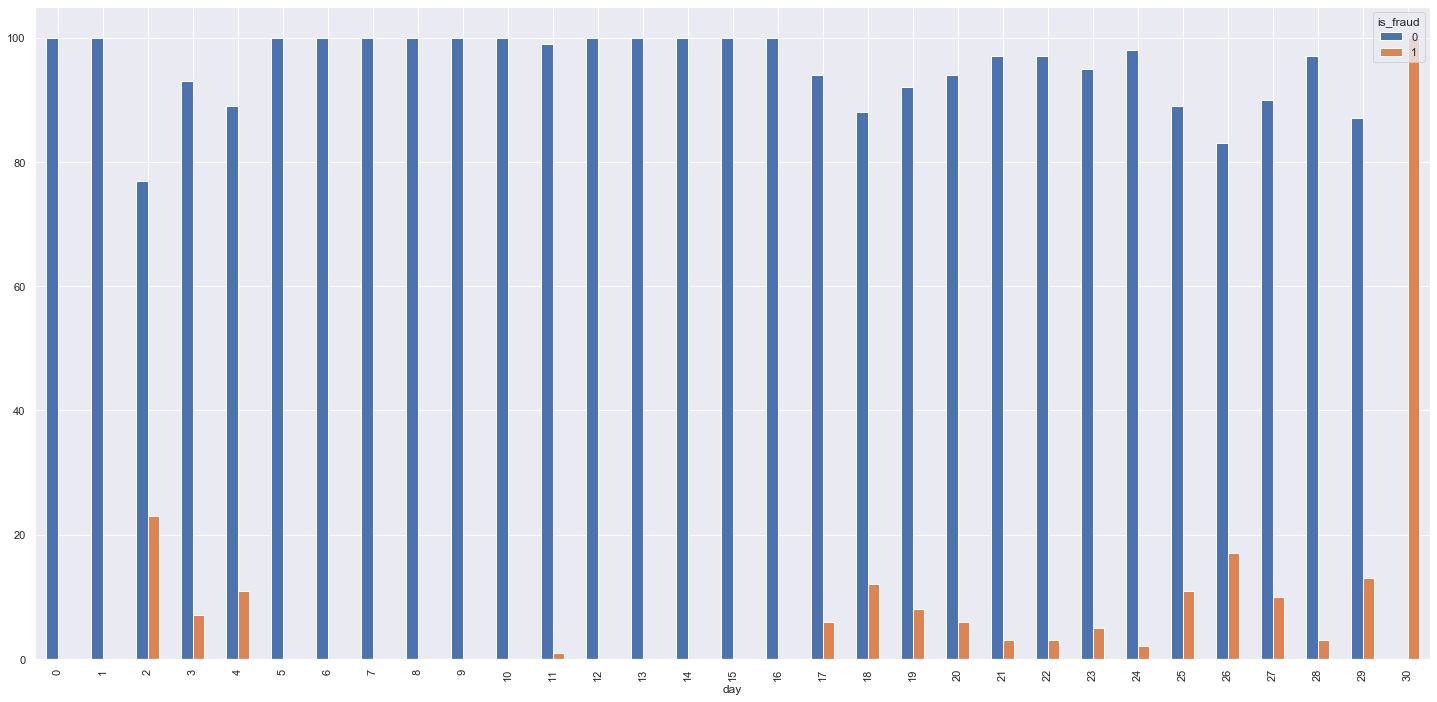

In [60]:
#check only fradulent cases
aux01 = pd.crosstab( df4['day'], df4['is_fraud'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar()

In [61]:
#print percentage by day
aux01.columns = ['Non-Fradulent','Fraudulent']
aux01

,Non-Fradulent,Fraudulent
day,,
0,100.0,0.0
1,100.0,0.0
2,77.0,23.0
3,93.0,7.0
4,89.0,11.0
5,100.0,0.0
6,100.0,0.0
7,100.0,0.0
8,100.0,0.0


Text(0.5, 1, 'is_fraud x day correlation heatmap')

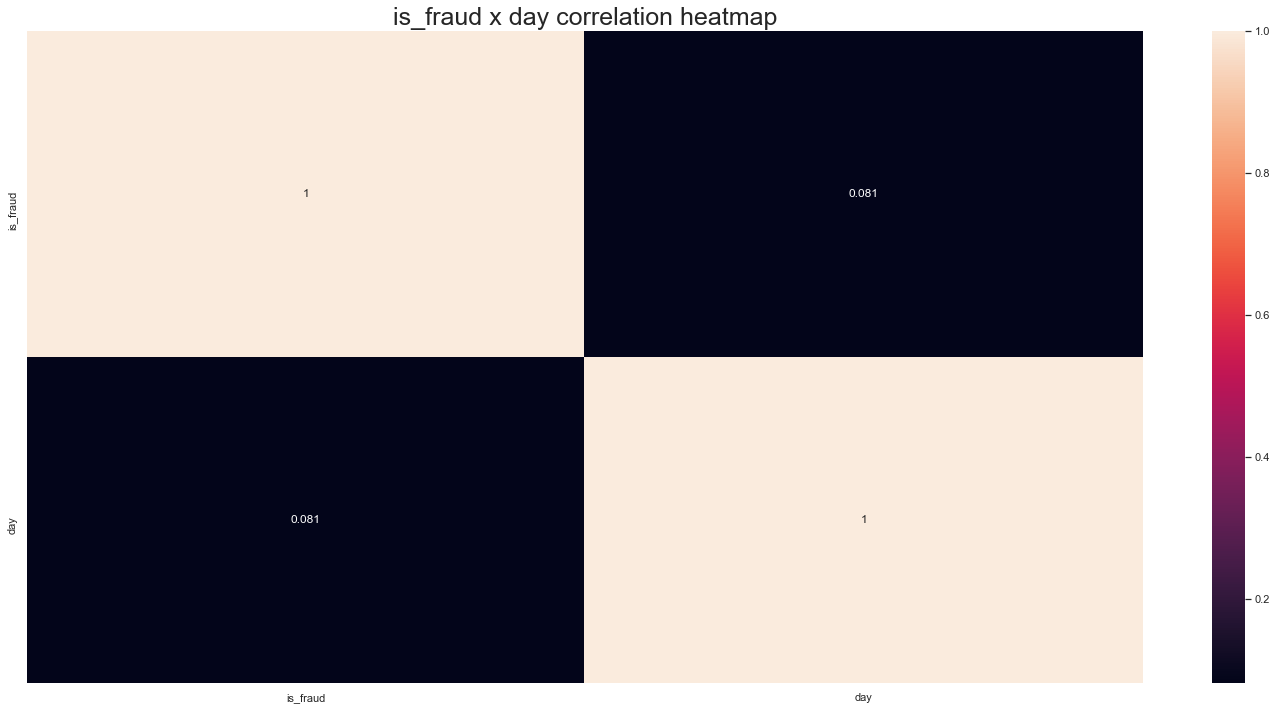

In [62]:
#correlation between is_fraud and day
point_bi(df4[['is_fraud']], df4[['day']])

- Although the amount of fraud per day does not fluctuate much, we have a higher percentage of fraudulent transactions after the first 15 days of the month.
- On the 3rd day of the month, 23% of transactions were considered fraudulent.
- We have a low and positive correlation between the variables is_fraud and day.
- The hypothesis is false: As a percentage, we have more fraudulent transactions after the first 15 days of the month.

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

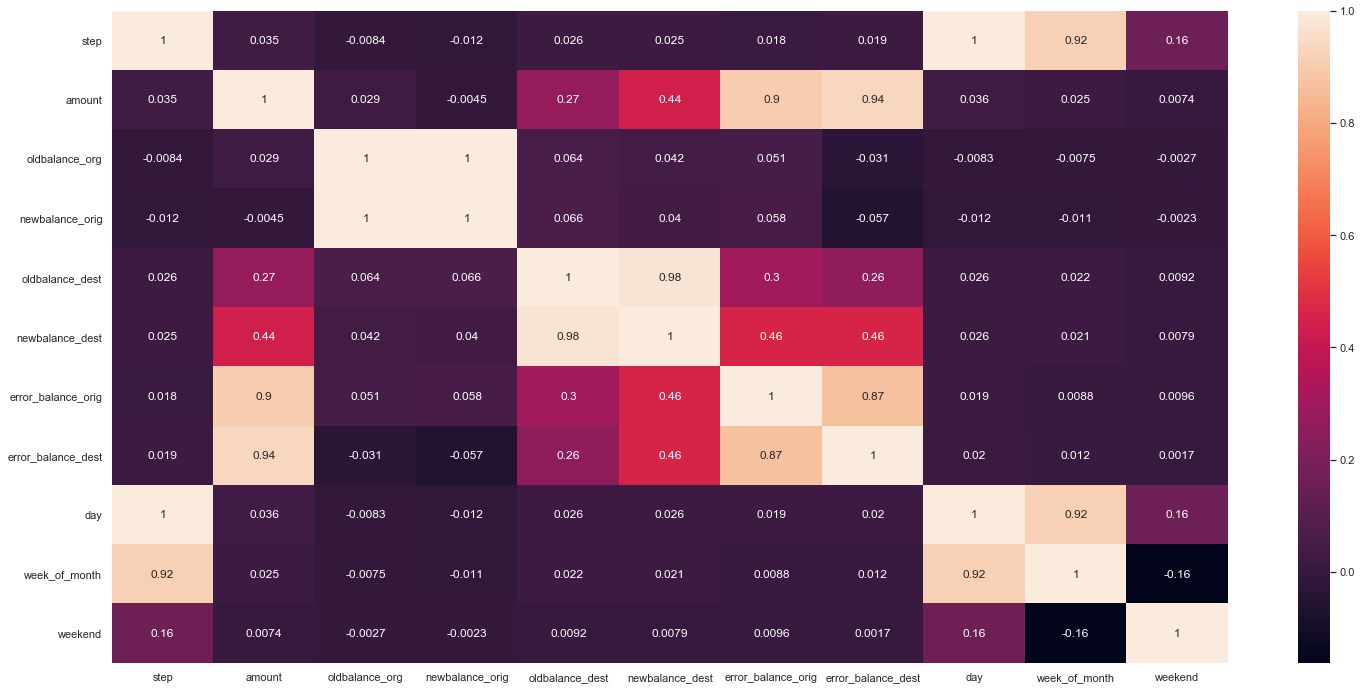

In [63]:
#selecting num_attributes to check the multivariate correlation
num_attributes = df4.select_dtypes(include = ['int64','float64'])

num_attributes.drop(columns = ['is_fraud','is_flagged_fraud'], axis = 1, inplace = True)

sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True)

Very correlated variables are not good for the models, as we would increase the dimensionality without placing relevant variables. That is, if we have two highly correlated variables, we remove one from it.

In this case, we have a high correlation between the variables:

- error_balance_orig x Erro_balance_dest
- newbalance_dest x oldbalance_dest
- error_balance_dest x amount
- error_balance_orig x amount

In [197]:
#copy of the dataframe
df5 = df4.copy()

In [198]:
#Splitting features and target variable
X = df5.drop(columns = 'is_fraud', axis = 1)
y = df5['is_fraud']

In [199]:
#split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 42)

In [200]:
#concat training data
df_train = X_train
df_train['is_fraud'] = y_train

# 5.0. DATA PREPARATION

In [40]:
#df7 = df_smt.copy()
df5 = df4.copy()

## 5.1. Rescaling

In this step, we will perform the rescaling of our numerical variables. For this, we need to check the presence of outliers in order to choose the best technique for our model. The techniques that will be used:

- RobustScaler -> Robust in the presence of outliers, therefore, in the variables that have a significant amount of outliers we will apply this technique.

- MinMaxScaler -> Sensitive in the presence of outliers, therefore, we will apply to our variables that do not have outliers.

In [41]:
num_attributes = df5.select_dtypes(exclude = 'object')

In [42]:
num_attributes.head()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,day,week_of_month,weekend
2,1,181.0,181.0,0.0,0.0,0.0,1,0,0.0,181.0,-181.0,0.0,0,1,0
3,1,181.0,181.0,0.0,21182.0,0.0,1,0,0.0,-21001.0,-181.0,-21182.0,0,1,0
251,1,2806.0,2806.0,0.0,0.0,0.0,1,0,0.0,2806.0,-2806.0,0.0,0,1,0
252,1,2806.0,2806.0,0.0,26202.0,0.0,1,0,0.0,-23396.0,-2806.0,-26202.0,0,1,0
680,1,20128.0,20128.0,0.0,0.0,0.0,1,0,0.0,20128.0,-20128.0,0.0,0,1,0


<AxesSubplot:xlabel='flow_dest'>

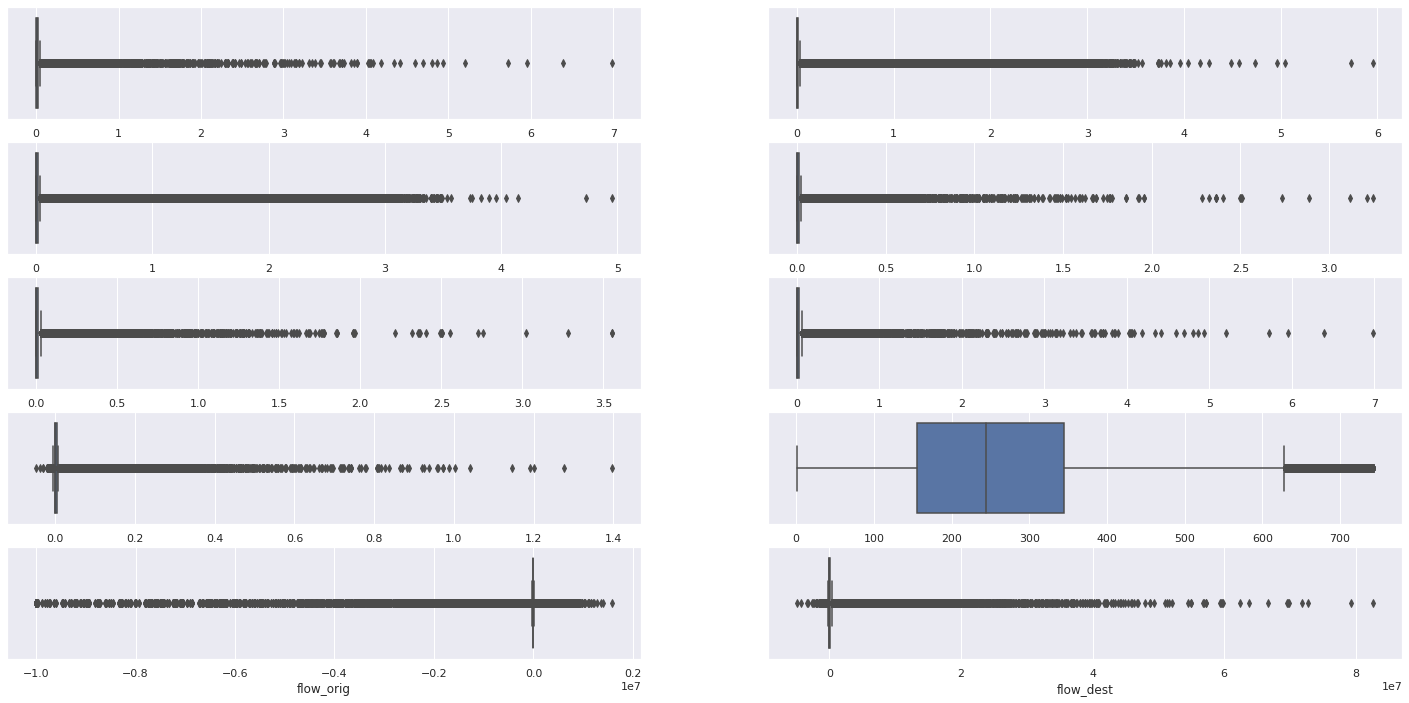

In [43]:
#amount
plt.subplot(5,2,1)
sns.boxplot(df5['amount'])

plt.subplot(5,2,2)
sns.boxplot(df5['oldbalance_org'])

plt.subplot(5,2,3)
sns.boxplot(df5['newbalance_orig'])

plt.subplot(5,2,4)
sns.boxplot(df5['oldbalance_dest'])

plt.subplot(5,2,5)
sns.boxplot(df5['newbalance_dest'])

plt.subplot(5,2,6)
sns.boxplot(df5['error_balance_orig'])

plt.subplot(5,2,7)
sns.boxplot(df5['error_balance_dest'])

plt.subplot(5,2,8)
sns.boxplot(df5['step'])

plt.subplot(5,2,9)
sns.boxplot(df5['flow_orig'])

plt.subplot(5,2,10)
sns.boxplot(df5['flow_dest'])

---- Robust Scaler -----
- amount
- oldbalance_org
- newbalance_org
- oldbalance_dest
- newbalance_dest 
- error_balance_orig
- error_balance_dest
- flow_orig
- flow_dest

----- MinMaxScaler -----
- step
- day

In [51]:
#define models
rs = RobustScaler()
mms = MinMaxScaler()

#RobustScaler
df5['amount'] = rs.fit_transform(df5[['amount']])
pickle.dump(rs, open("parameter/scaler_amount.pkl",'wb'))

df5['oldbalance_org'] = rs.fit_transform(df5[['oldbalance_org']])
pickle.dump(rs, open("parameter/scaler_oldbalance_org.pkl",'wb'))

df5['newbalance_orig'] = rs.fit_transform(df5[['newbalance_orig']])
pickle.dump(rs, open("parameter/scaler_newbalance_orig.pkl",'wb'))

df5['oldbalance_dest'] = rs.fit_transform(df5[['oldbalance_dest']])
pickle.dump(rs, open("parameter/scaler_oldbalance_dest.pkl",'wb'))

df5['newbalance_dest'] = rs.fit_transform(df5[['newbalance_dest']])
pickle.dump(rs, open("parameter/scaler_newbalance_dest.pkl",'wb'))

df5['error_balance_orig'] = rs.fit_transform(df5[['error_balance_orig']])
pickle.dump(rs, open("parameter/scaler_error_balance_orig.pkl",'wb'))

df5['error_balance_dest'] = rs.fit_transform(df5[['error_balance_dest']])
pickle.dump(rs, open("parameter/scaler_error_balance_dest.pkl",'wb'))

df5['flow_orig'] = rs.fit_transform(df5[['flow_orig']])
pickle.dump(rs, open("parameter/scaler_flow_orig.pkl",'wb'))

df5['flow_dest'] = rs.fit_transform(df5[['flow_dest']])
pickle.dump(rs, open("parameter/scaler_flow_dest.pkl",'wb'))


#MinMaxScaler
df5['step'] = mms.fit_transform(df5[['step']])
pickle.dump(mms, open("parameter/scaler_step.pkl",'wb'))

df5['day'] = mms.fit_transform(df5[['day']])
pickle.dump(mms, open("parameter/scaler_day.pkl",'wb'))

In [45]:
df5.head() 

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend
2,0.0,TRANSFER,-0.383807,-0.131599,0.0,-0.138622,-0.193813,1,0,-0.271268,-0.091993,-0.017350,0.000000,Costumer,Costumer,0.0,1,0
3,0.0,CASH_OUT,-0.383807,-0.131599,0.0,-0.115937,-0.193813,1,0,-0.271268,-0.160639,-0.017350,-0.141582,Costumer,Costumer,0.0,1,0
251,0.0,TRANSFER,-0.370502,-0.107971,0.0,-0.138622,-0.193813,1,0,-0.271268,-0.083486,-0.268979,0.000000,Costumer,Costumer,0.0,1,0
252,0.0,CASH_OUT,-0.370502,-0.107971,0.0,-0.110561,-0.193813,1,0,-0.271268,-0.168400,-0.268979,-0.175137,Costumer,Costumer,0.0,1,0
680,0.0,TRANSFER,-0.282706,0.047950,0.0,-0.138622,-0.193813,1,0,-0.271268,-0.027349,-1.929440,0.000000,Costumer,Costumer,0.0,1,0


## 5.2. Encoding

We applied the label encoder so that, in the feature selection stage, we could apply the algorithms.

In [46]:
client = {'Costumer':'0','Merchant':1}
types = {"CASH_OUT":0,'PAYMENT':1,'CASH_IN':2, 'TRANSFER':3,'DEBIT':4}

#encoding
df5['client_dest'] = df5['client_dest'].map(client)
df5['client_orig'] = df5['client_orig'].map(client)
df5['type'] = df5['type'].map(types)

# 6.0. FEATURE SELECTION

In this part, we will use 3 ways of selecting features:

- RFE (Recursive Feature Elimination)
- Random Forest
- Boruta

We will check the similarity of the selected features and from there, decide which one we will take into consideration.

In [47]:
df6=df5.copy()

In [48]:
#split data
X = df6.drop(columns = 'is_fraud', axis = 1)
y = df6['is_fraud']

## 6.1. Recursive Feature Elimination (RFE)

In [158]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#feature selector
selector = RFE(rf, n_features_to_select = 7, step = 1)
selector = selector.fit(X,y)

#get ranking
selector.support_

array([ True, False,  True,  True,  True, False,  True, False,  True,
       False,  True, False, False, False, False, False, False])

In [160]:
X.head()

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend
6012298,0.602426,0,0.692465,0.046820,0.000000,-0.138319,-0.000180,0,0.514568,1.284669,-1.904480,1.420394,0,0,0.600000,3,0
6127425,0.726415,1,-0.339985,1.232705,1.005176,-0.138319,-0.191569,0,-0.271782,-0.063363,-0.857241,0.000000,1,0,0.733333,4,0
3794542,0.377358,1,-0.366134,-0.118289,0.000000,-0.138319,-0.191569,0,-0.263330,-0.080066,-0.166792,0.000000,1,0,0.366667,2,0
2308765,0.252022,0,0.475830,-0.134137,0.000000,1.487678,1.332356,0,0.421555,1.007915,0.000000,1.134938,0,0,0.233333,1,1
1100355,0.173854,0,0.247698,-0.134137,0.000000,0.996147,0.877405,0,0.237915,0.716474,0.000000,0.834334,0,0,0.166667,1,0


In [161]:
columns_selected = ['step','amount','oldbalance_org','newbalance_orig','error_balance_orig','error_balance_dest','client_dest']
columns_selected

['step',
 'amount',
 'oldbalance_org',
 'newbalance_orig',
 'error_balance_orig',
 'error_balance_dest',
 'client_dest']

## 6.2. RandomForest as a Feature Selector

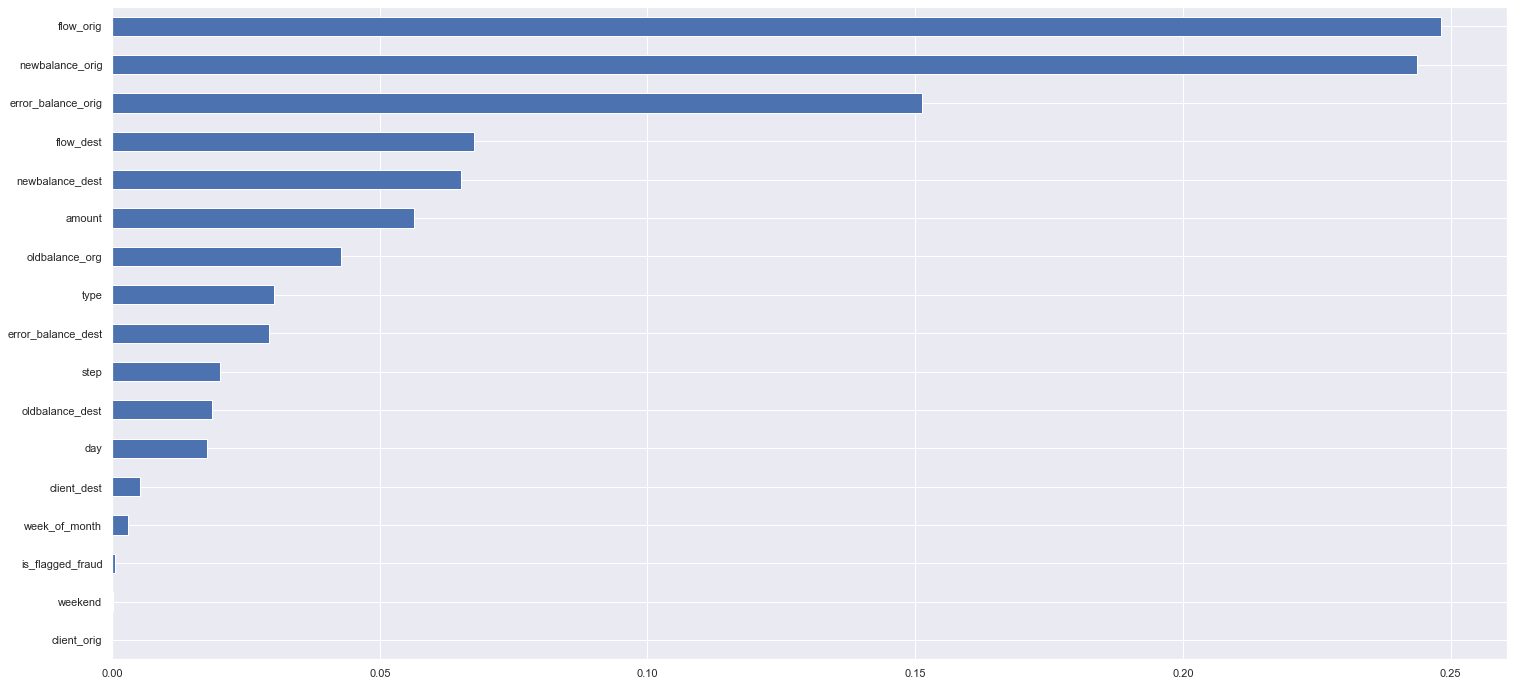

In [162]:
#feature importances 
rf_model = RandomForestClassifier(n_jobs = -1)
rf_model.fit(X, y)

feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')

In [ ]:
cols_selected_rf = ['flow_orig','flow_dest', 'amount','oldbalance_org','newbalance_orig','error_balance_orig','error_balance_dest','type']

## 6.3. Boruta as Feature Selector

In [163]:
#define model
#xgb_model = xgb.XGBClassifier(n_jobs=-1)
extra_model = ExtraTreesClassifier(n_jobs=-1)
rf_model = RandomForestClassifier(n_jobs = -1)

#split data 
X_train_nn = X.values
y_train_nn = y.values.ravel()

#define boruta
boruta = BorutaPy(extra_model, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_nn, y_train_nn)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	5


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	5


In [165]:
#best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['step',
 'type',
 'amount',
 'oldbalance_org',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'error_balance_orig',
 'error_balance_dest',
 'flow_orig',
 'flow_dest',
 'day']

## 6.4. Manual Feature Selection

From the features selected by each model, we select those that were in common and add those that we think are relevant to the model. We realized that the boruto algorithm was able to cover the relevant features of RFE and RandomForest, therefore, we will select the features that it provided us.

In [49]:
##features that will be really important to our model
cols_selected = ['type',
 'amount',
 'oldbalance_org',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'error_balance_orig',
 'error_balance_dest',
 'flow_orig',
 'flow_dest',
 'day','is_fraud']

#creating a dataframe with selected columns
df6 = df6[cols_selected]

# 7.0. BALANCED DATASET (SMOTE + TOMEKLINK)

In the fraud detection example (where the number of normal financial transactions is far greater than the number of fraudulent transactions), a classifier will tend to present many false negatives - an undesirable situation for a bank, obviously. To avoid this, we will perform an Oversampling + Undersampling technique known as SMOTE + Tomeklink to balance the data.

In [ ]:
df7 = df6.copy()

In [212]:
#target variable and features split 
X = df7.drop(columns = 'is_fraud',axis = 1)
y = df7['is_fraud']

#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [213]:
#concat datast
X_train['is_fraud'] = y_train

In [214]:
#Smote + Tomeklink
#define sampler
smt = c.SMOTETomek(sampling_strategy = 'auto', random_state = 32, n_jobs = -1)

#apply sampler
x_smt, y_smt = smt.fit_resample(X_train, X_train['is_fraud'])

In [215]:
y_smt.value_counts()

1    559979
0    559979
Name: is_fraud, dtype: int64

In [219]:
X_train = X_train.drop(columns = 'is_fraud', axis = 1)
y_train = y_smt

# 8.0. MACHINE LEARNING MODELLING

## 8.1. Logistic Regression

In [220]:
#define model
logreg = LogisticRegression()

#training model
model = logreg.fit(X_train.values,y_train.values)

#predict model
yhat_log = model.predict(X_test)

#performance
result_log = pd.DataFrame(["Logistic Regression",accuracy_score(y_test,yhat_log),cohen_kappa_score(y_test,yhat_log),
                          recall_score(y_test,yhat_log), f1_score(y_test,yhat_log),
                           precision_score(y_test,yhat_log)]).T
result_log.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_log))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    240006
           1       0.18      0.89      0.30      1965

    accuracy                           0.97    241971
   macro avg       0.59      0.93      0.64    241971
weighted avg       0.99      0.97      0.98    241971



In [221]:
#print result summary
result_log

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Logistic Regression,0.96638,0.290763,0.88855,0.300335,0.180708


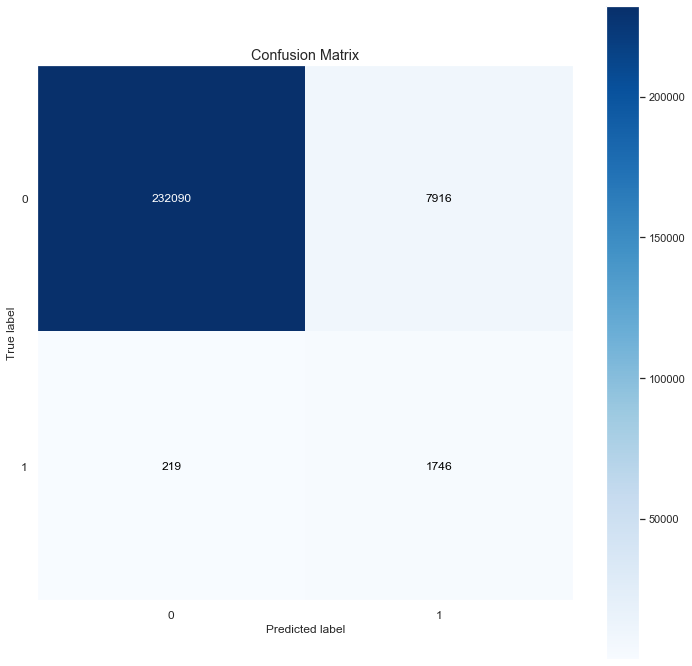

In [222]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_log, normalize = False, figsize = (12,12))

## 8.2. Stochastic Gradient Descent

In [240]:
#model definition
sgb = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

#fit model
sgb.fit(X_train,y_train)

#prediction
yhat_sgb = sgb.predict(X_test)

#performance
result_sgb = pd.DataFrame(["Stochastic Gradient Descent",accuracy_score(y_test,yhat_sgb),cohen_kappa_score(y_test,yhat_sgb),
                          recall_score(y_test,yhat_sgb), f1_score(y_test,yhat_sgb),
                          precision_score(y_test,yhat_sgb)]).T
result_sgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_sgb))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    240006
           1       0.15      0.91      0.26      1965

    accuracy                           0.96    241971
   macro avg       0.57      0.93      0.62    241971
weighted avg       0.99      0.96      0.97    241971



In [241]:
result_sgb

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Stochastic Gradient Descent,0.957239,0.245355,0.905344,0.255879,0.148995


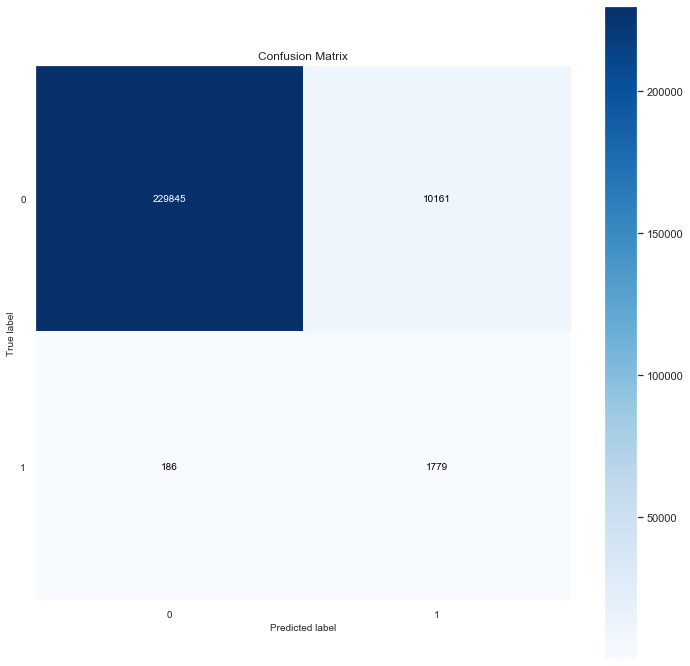

In [242]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_sgb, normalize = False, figsize = (12,12))

## 8.3. RandomForestClassifier

In [227]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#training model
rf.fit(X_train, y_train)

#predict model
yhat_rf = rf.predict(X_test)

#performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),
                           precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    240006
           1       0.99      1.00      0.99      1965

    accuracy                           1.00    241971
   macro avg       0.99      1.00      1.00    241971
weighted avg       1.00      1.00      1.00    241971



In [228]:
result_rf

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.999876,0.992343,0.997455,0.992405,0.987406


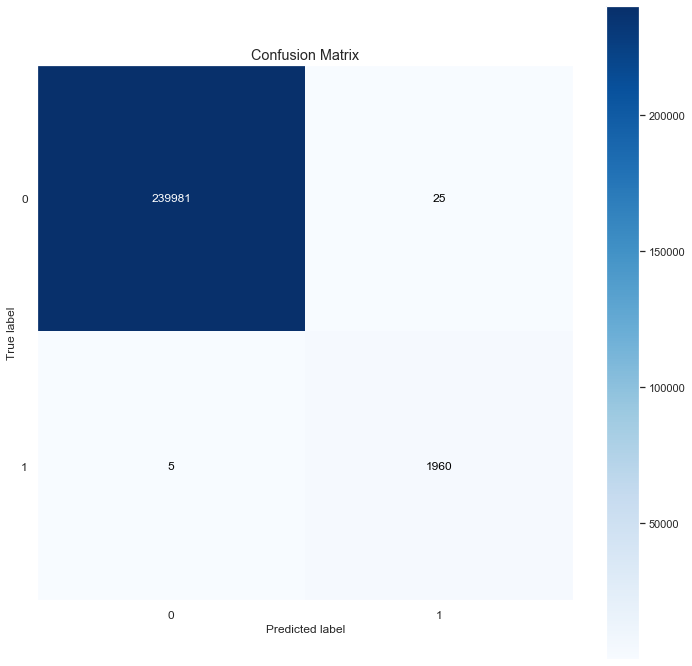

In [229]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_rf, normalize = False, figsize = (12,12))

## 8.4. LGBMClassifier

In [223]:
#define model
lgbm = LGBMClassifier(n_jobs = -1)

#train_model
lgbm.fit(X_train.values, y_train.values)

#predict model
yhat_lgbm = lgbm.predict(X_test)

#performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),cohen_kappa_score(y_test,yhat_lgbm),
                          recall_score(y_test,yhat_lgbm), f1_score(y_test,yhat_lgbm),
                           precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    240006
           1       0.98      1.00      0.99      1965

    accuracy                           1.00    241971
   macro avg       0.99      1.00      0.99    241971
weighted avg       1.00      1.00      1.00    241971



In [224]:
result_lgbm

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,LGBM Classifier,0.999793,0.987301,0.997455,0.987406,0.977556


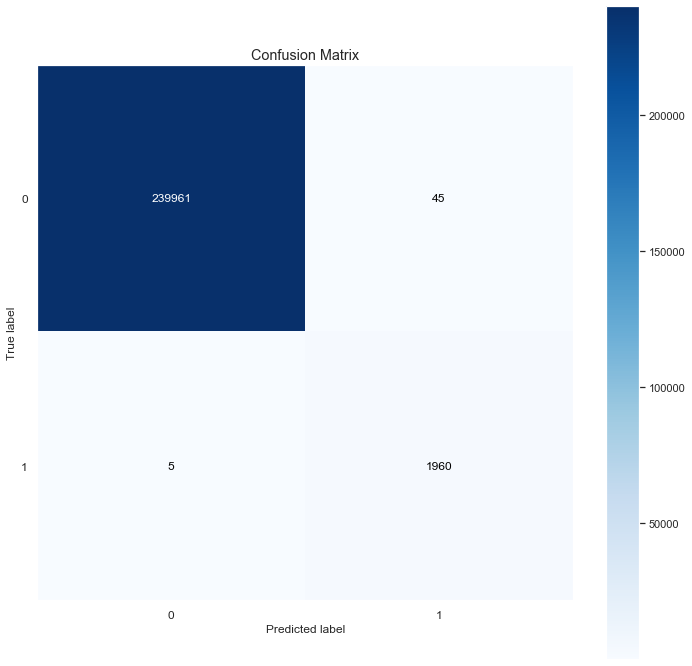

In [225]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize = False, figsize = (12,12))

## 8.5. Machine Learning Performance

In [244]:
#concat each performance as a dataframe
performance = pd.concat([result_log,result_rf,result_lgbm,result_sgb])
performance.sort_values('Precision_score', ascending = False)

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.999876,0.992343,0.997455,0.992405,0.987406
0,LGBM Classifier,0.999793,0.987301,0.997455,0.987406,0.977556
0,Logistic Regression,0.96638,0.290763,0.88855,0.300335,0.180708
0,Stochastic Gradient Descent,0.957239,0.245355,0.905344,0.255879,0.148995


- Random Forest is the machine learning model with the best performance.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.975
LGBM: ROC AUC=1.000
RandomForestClassifier: ROC AUC=0.999


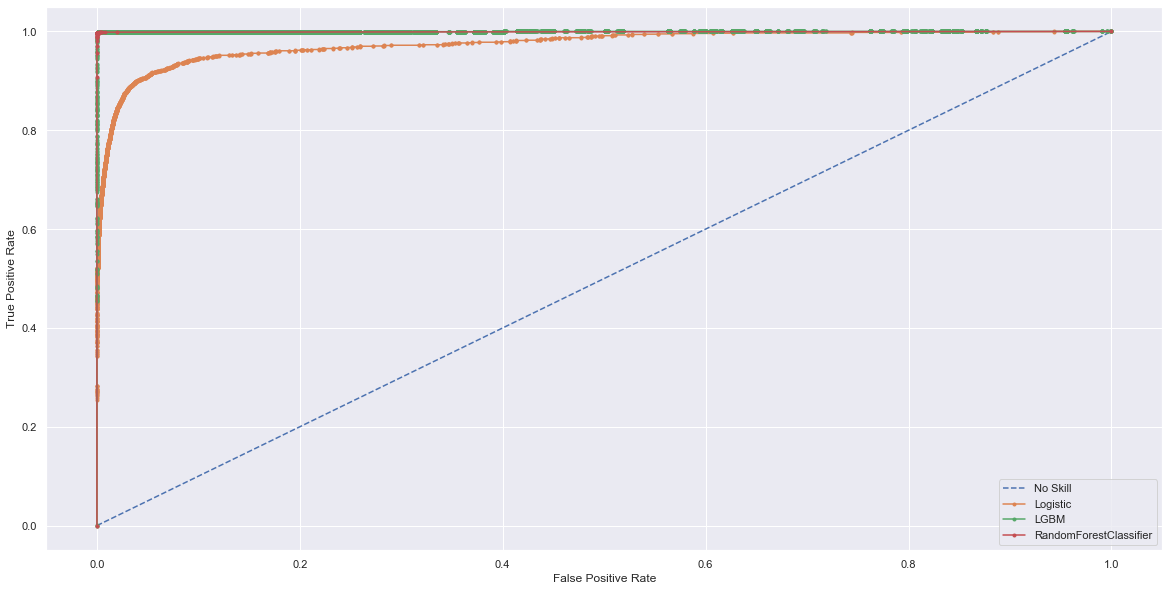

In [250]:
#machine leraning model
lr_probs = logreg.predict_proba(X_test)
lgbm_probs = lgbm.predict_proba(X_test)
#sgb_probs = sgb.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)


# keep probabilities for the positive outcome only
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_probs[:, 1]
lgbm_probs = lgbm_probs[:,1]
#sgb_probs = knn_probs[:,1]
rf_probs = rf_probs[:,1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
#sgb_auc = roc_auc_score(y_test, knn_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
#print('Stochastic Gradient Descent: ROC AUC=%.3f' % (sgb_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)
#sgb_fpr, sgb_tpr, _ = roc_curve(y_test, sgb_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

#plot
plt.figure(figsize = (20,10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
#plt.plot(sgb_fpr, sgb_tpr, marker='.', label='SGB')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForestClassifier')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## 8.6 RandomForestClassifier - Cross-Validation - Real Performance

In [246]:
#cross validation scores
rf_cv = cross_val_score(rf,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

Average: 0.9998 +/- Std 0.0


In [247]:

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_cv),4),np.round(np.std(rf_cv),6)))

Average: 0.9998 +/- Std 4.1e-05


# 9.0. HYPERPARAMETER FINE TUNNING

## 9.1. Random Search CV

In [251]:
#define model
rf_hyper = RandomForestClassifier(n_jobs = -1, random_state = 42)

#parameters
parameters =  {'max_depth': np.arange(2, 12, 2), 
         'n_estimators': np.arange(10, 105, 15)}

#define random search cv
rf_hyper_cv = RandomizedSearchCV(estimator=rf_hyper, param_distributions=parameters,
                                scoring='accuracy', n_iter=100, cv=10, verbose=2,
                                random_state=42, n_jobs=-1)

#fit RandomSearchCV
rf_hyper_cv.fit(X_train, np.ravel(y_train))

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 88.8min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 351.5min finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100])},
                   random_state=42, scoring='accuracy', verbose=2)

In [253]:
#get the best parameters to our model
rf_hyper_cv.best_estimator_

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

## 9.2. Fit the model with the best parameters

In [254]:
#define model
rf_hyper = RandomForestClassifier(max_depth = 10, n_jobs = -1, random_state = 42)

#fit the model
rf_hyper.fit(X_train.values,y_train.values)

#predict model
yhat_rf_hyper = rf_hyper.predict(X_test)

#performance

#performance
result_rf_hyper = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf_hyper),cohen_kappa_score(y_test,yhat_rf_hyper),
                          recall_score(y_test,yhat_rf_hyper), f1_score(y_test,yhat_rf_hyper),
                           precision_score(y_test,yhat_rf_hyper)]).T
result_rf_hyper.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf_hyper))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    240006
           1       1.00      1.00      1.00      1965

    accuracy                           1.00    241971
   macro avg       1.00      1.00      1.00    241971
weighted avg       1.00      1.00      1.00    241971



In [291]:
result_rf_hyper

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.999963,0.997691,0.997455,0.997709,0.997963


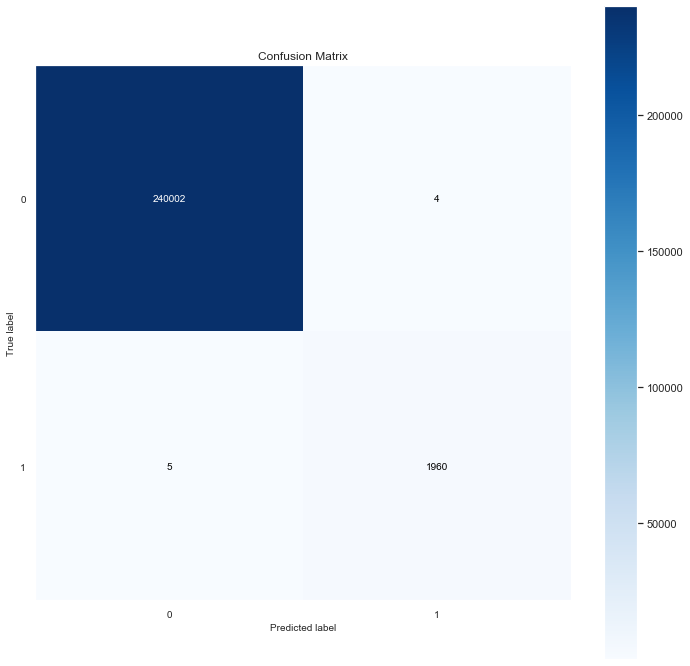

In [256]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_rf_hyper, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(rf_hyper, X_train, y_train);

In [271]:
#save model in picke
pickle.dump(rf_hyper,open('C:\ProjetosDataScience\ComunidadeDS\model\model.pkl','wb'))

## 9.3. Real Performance - Cross-Validation

In [260]:
#cross validation scores
rf_hyper_cv_final = cross_val_score(rf_hyper,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_hyper_cv_final),4),np.round(np.std(rf_hyper_cv_final),4)))

Average: 0.999 +/- Std 0.0001


# 10.0. BUSINESS PERFORMANCE

First of all, let's remember what is the business model:

- **1** - The company receives 25% of each transaction value truly detected as fraud.
- **2** - The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
- **3** - The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

###  What do we need to show? 

- What is the model's Precision and Accuracy?
- How Reliable is the model in classifying transactions as legitimate or fraudulent?
- What is the Expected Billing by the Company if we classify 100% of transactions with the model?

## 10.1 Finacial Return

In [337]:
X_test['is_fraud'] = y_test
X_test['predictions'] = yhat_rf_hyper
X_test['amount'] = rs.inverse_transform(X_test)

In [358]:
#1 - transaction that is truly detected as fraud
fraudulent_transactions = X_test[(X_test['is_fraud'] == 1) & (X_test['predictions'] == 1)]
fraudulent_detected = fraudulent_transactions[['amount','is_fraud','predictions']].groupby(["is_fraud",'predictions']).sum().reset_index()
fraudulent_detected['gain'] = np.round(fraudulent_detected['amount']*0.25,4)

print("1 --- Using a sample with 241971 costumers,Blocker Fraud Company will Recieve ${:,.2f} due to transactions truly detected as fraud".format(fraudulent_detected['gain'][0]))

#2 -The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
aux1 = X_test[(X_test['is_fraud'] == 0) & (X_test['predictions'] == 1)]
aux2 = aux1[['is_fraud','predictions','amount']].groupby(['is_fraud','predictions']).sum().reset_index()
aux2['gain'] = aux2['amount']*0.05

print("\n")
print("2 --- Using a sample with 241971, Blocker Fraud Comapany will receive ${:,.2f} due to transactions detected as fraud, but actually it was legitimate.".format(aux2['gain'][0]))

#3 -The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.
aux3 = X_test[(X_test['is_fraud'] == 1) & (X_test['predictions'] == 0)]
aux3 = aux3[['is_fraud','predictions','amount']].groupby(['is_fraud','predictions']).sum().reset_index()
aux3['gain'] = aux3['amount']*1

print("\n")
print("3 --- Using a sample with 241971, Blocker Fraud Company will receive ${:,.2f} due to transactions detected as legitimate, but actually it was fraudulent".format(aux3['gain'][0]))

1 --- Using a sample with 241971 costumers,Blocker Fraud Company will Recieve $110,914,765.84 due to transactions truly detected as fraud


2 --- Using a sample with 241971, Blocker Fraud Comapany will receive $0.00 due to transactions detected as fraud, but actually it was legitimate.


3 --- Using a sample with 241971, Blocker Fraud Company will receive $898,095.27 due to transactions detected as legitimate, but actually it was fraudulent


## 10.2. Model's Performance and Business

In [368]:
#print results
print("What is the model's Precision and Accuracy?")
print("\n")
print("----- Precision -----")
print(0.997963)
print("----- Accuracy ------")
print(0.999963)

print("\n")
print("How Reliable is the model in classifying transactions as legitimate or fraudulent?")
print("\n")
print("Answer -----> The model can detect 99% of the fraudulent transactions. The false positive rate is only 0.001%.")
print("\n")

print("- What is the Expected Billing by the Company if we classify 100% of transactions with the model?")
print("\n")
print("Answer ----- Finacial Return - ${:,.2f}".format(aux3['gain'][0]))

What is the model's Precision and Accuracy?


----- Precision -----
0.997963
----- Accuracy ------
0.999963


How Reliable is the model in classifying transactions as legitimate or fraudulent?


Answer -----> The model can detect 99% of the fraudulent transactions. The false positive rate is only 0.001%.


- What is the Expected Billing by the Company if we classify 100% of transactions with the model?


----- Finacial Return - $898,095.27


# 11.0. DEPLOY MODEL TO PRODUCTION

## 11.1. Fraud Class

In [66]:
import pickle
import pandas as pd
import numpy as np
import inflection

class FraudDetection( object ):
    def __init__(self):
        
        #load scalers
        self.amount_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_amount.pkl",'rb'))
        self.oldbalance_org_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_oldbalance_org.pkl",'rb'))
        self.newbalance_orig_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_newbalance_orig.pkl",'rb'))
        self.oldbalance_dest_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_oldbalance_dest.pkl",'rb'))
        self.newbalance_dest_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_newbalance_dest.pkl",'rb'))
        self.error_balance_orig_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_error_balance_orig.pkl",'rb'))
        self.error_balance_dest_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_error_balance_dest.pkl",'rb'))
        self.flow_orig_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_flow_orig.pkl",'rb'))
        self.flow_dest_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_flow_dest.pkl",'rb'))
        self.step_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_step.pkl",'rb'))
        self.day_scaler = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/parameter/scaler_day.pkl",'rb'))

    def data_cleaning(self, df1):
        
        ## 1.1. Rename Columns
        cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
               'nameDest', 'oldbalanceDest', 'newbalanceDest','isFlaggedFraud']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase,cols_old))
        cols_new

        #change columns names
        df1.columns = cols_new        
        return df1

    
    def feature_engineering(self, df2):
        
        ## 2.4. Feature Engineering

        #error balance 
        df2['error_balance_orig'] = np.round((df2['newbalance_orig'] + df2['amount'] - df2['oldbalance_org']),2)
        df2['error_balance_dest'] = df2['newbalance_dest'] + df2['amount'] - df2['oldbalance_dest']
        df2['flow_orig'] = df2['newbalance_orig'] - df2['oldbalance_org']
        df2['flow_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

        #client
        df2['client_dest'] = df2['name_dest'].apply(lambda x: "Merchant" if "M" in x else "Costumer")
        df2['client_orig'] = df2['name_orig'].apply(lambda x: 'Merchant' if "M" in x else "Costumer")

        #step
        df2['day'] = df2['step'].apply(lambda x: int(x/24))

        #weekend
        df2['week_of_month'] = df2['day'].apply(lambda x: 1 if (x <=7) else 2 if (x <= 14) & (x>7) else 3 if (x > 14) & (x<=21) else 4)

        #weekend
        df2['weekend'] = df2['day'].apply(lambda x: 1 if (x == 7) or (x == 6) or (x == 14) or (x == 13) or (x == 20) or (x == 21) or (x == 27) or (x == 28) else 0)

        ##DATA FILTERING
        
        #removing features that will not necessary to us
        df2.drop(columns = ['name_orig','name_dest'], axis = 1, inplace = True)

        #amount
        df2 = df2[df2['amount'] < 2.108805e+06]

        #oldbalance_org
        df2 = df2[df2['oldbalance_dest'] < 9.384180e+06]
        
        return df2
    
    def data_preparation(self, df5):

        #RobustScaler
        df5['amount'] = self.amount_scaler.fit_transform(df5[['amount']])

        df5['oldbalance_org'] = self.oldbalance_org_scaler.fit_transform(df5[['oldbalance_org']])

        df5['newbalance_orig'] = self.newbalance_orig_scaler.fit_transform(df5[['newbalance_orig']])

        df5['oldbalance_dest'] = self.oldbalance_dest_scaler.fit_transform(df5[['oldbalance_dest']])

        df5['newbalance_dest'] = self.newbalance_dest_scaler.fit_transform(df5[['newbalance_dest']])

        df5['error_balance_orig'] = self.error_balance_orig_scaler.fit_transform(df5[['error_balance_orig']])

        df5['error_balance_dest'] = self.error_balance_dest_scaler.fit_transform(df5[['error_balance_dest']])

        df5['flow_orig'] = self.flow_orig_scaler.fit_transform(df5[['flow_orig']])

        df5['flow_dest'] = self.flow_dest_scaler.fit_transform(df5[['flow_dest']])


        #MinMaxScaler
        df5['step'] = self.step_scaler.fit_transform(df5[['step']])

        df5['day'] = self.day_scaler.fit_transform(df5[['day']])

        ##ENCODING
        client = {'Costumer':'0','Merchant':1}
        types = {"CASH_OUT":0,'PAYMENT':1,'CASH_IN':2, 'TRANSFER':3,'DEBIT':4}

        #encoding
        df5['client_dest'] = df5['client_dest'].map(client)
        df5['client_orig'] = df5['client_orig'].map(client)
        df5['type'] = df5['type'].map(types)

        ##features that will be really important to our model
        cols_selected = ['type','amount','oldbalance_org','newbalance_orig','oldbalance_dest','newbalance_dest','error_balance_orig','error_balance_dest','flow_orig','flow_dest','day']

        #creating a dataframe with selected columns
        df5 = df5[cols_selected]
        
        return df5
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records')

## 11.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response

from frauddetection.FraudDetection import FraudDetection

#loading model
model = pickle.load(open("/home/jorge/jorge/pa002_blocker_fraud_company/model/model.pkl",'rb'))

app = Flask(__name__)
@app.route("/frauddetection/predict", methods =['POST'])
def fraud_detection():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = FraudDetection()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, df2, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 11.3. API Tester

In [2]:
import requests

In [25]:
#drop is_fraud column
df_test = df_raw.sample(10000).drop(columns = 'isFraud', axis = 1)

#convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [26]:
#API Call
#url = 'http://0.0.0.0:5000/frauddetection/predict' #localhost
url = 'https://fraud-detection-test.herokuapp.com/frauddetection/predict' #api web
header = {'Content-type': 'application/json'} 
data = data

r = requests.post(url, data, headers = header)
print("Status Code {}".format(r.status_code))

Status Code 200


In [27]:
r.json()

[{'step': 94,
  'type': 'CASH_OUT',
  'amount': 248196.76,
  'oldbalance_org': 0.0,
  'newbalance_orig': 0.0,
  'oldbalance_dest': 413349.1,
  'newbalance_dest': 661545.86,
  'is_flagged_fraud': 0,
  'error_balance_orig': 248196.76,
  'error_balance_dest': 496393.52,
  'flow_orig': 0.0,
  'flow_dest': 248196.76,
  'client_dest': 'Costumer',
  'client_orig': 'Costumer',
  'day': 3,
  'week_of_month': 1,
  'weekend': 0,
  'prediction': 0},
 {'step': 355,
  'type': 'PAYMENT',
  'amount': 1329.53,
  'oldbalance_org': 76102.48,
  'newbalance_orig': 74772.94,
  'oldbalance_dest': 0.0,
  'newbalance_dest': 0.0,
  'is_flagged_fraud': 0,
  'error_balance_orig': -0.01,
  'error_balance_dest': 1329.53,
  'flow_orig': -1329.54,
  'flow_dest': 0.0,
  'client_dest': 'Merchant',
  'client_orig': 'Costumer',
  'day': 14,
  'week_of_month': 2,
  'weekend': 1,
  'prediction': 0},
 {'step': 45,
  'type': 'PAYMENT',
  'amount': 1681.96,
  'oldbalance_org': 313363.0,
  'newbalance_orig': 311681.04,
  'oldb

In [28]:
df = pd.DataFrame(r.json(), columns = r.json()[0].keys()) 

In [31]:
df.head()

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_flagged_fraud,error_balance_orig,error_balance_dest,flow_orig,flow_dest,client_dest,client_orig,day,week_of_month,weekend,prediction
0,94,CASH_OUT,248196.76,0.00,0.00,413349.10,661545.86,0,248196.76,496393.52,0.00,248196.76,Costumer,Costumer,3,1,0,0
1,355,PAYMENT,1329.53,76102.48,74772.94,0.00,0.00,0,-0.01,1329.53,-1329.54,0.00,Merchant,Costumer,14,2,1,0
2,45,PAYMENT,1681.96,313363.00,311681.04,0.00,0.00,0,0.00,1681.96,-1681.96,0.00,Merchant,Costumer,1,1,0,0
3,353,CASH_OUT,157681.35,211730.00,54048.65,5883101.92,6040783.27,0,0.00,315362.70,-157681.35,157681.35,Costumer,Costumer,14,2,1,0
4,35,CASH_OUT,167499.13,0.00,0.00,497420.43,664919.56,0,167499.13,334998.26,0.00,167499.13,Costumer,Costumer,1,1,0,0


In [30]:
df.to_csv("data/df.csv")

In [33]:
df['amount'].mean()

145047.58282164496